In [ ]:
!pip install transformers openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.4 MB/s eta 0:00:00


## Table of Conents

>>[Load Data](#scrollTo=XTLWpTOqVTdh)

>>[Split Data into Training, Validation, and Testing Datasets](#scrollTo=gcbDbQ73VfvJ)

>>[Fine Tune the Last Layer of Twitter Roberta](#scrollTo=xCuz5VeoXWjz)

>>>>[Download Model from Hugging Face: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest](#scrollTo=L7KYUi-7P9pu)

>>>>[Define Hyperparameters](#scrollTo=MVPeHS6tQTZd)

>>>>[Model Training](#scrollTo=B697vGAGRuFW)

>>>>[Load Fine-Tuned Model](#scrollTo=bA4wWVapR579)

>>>>[Make Predictions on the testing dataset](#scrollTo=YHHG_ppASA0D)

>>[Directly Apply OpenAI on the Whole Dataset](#scrollTo=CLq4gTGBmVEF)

>>[Compare OpenAI with Twitter Roberta on Testing Dataset](#scrollTo=7W5WYmRUmVUW)



In [ ]:
import json
import numpy as np
import seaborn as sns

import openai

from tqdm import tqdm
from scipy.special import softmax
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, Callback

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- dowload dataset from https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data

In [ ]:
stock_df = pd.read_csv('/content/drive/MyDrive/tweets_labelled_09042020_16072020.csv', sep=';')

In [ ]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def text_to_label(x):
    if x == 'negative':
        return 0
    elif x == 'neutral':
        return 1
    elif x == 'positive':
        return 2

def get_var(df, var_name):
    globals()[var_name] = df
    return df

In [ ]:
stock_df_processed = (
    stock_df.query("~sentiment.isna()")
        .assign(text=lambda df_:
    df_.text.apply(preprocess))
        .rename(columns={'sentiment': 'sentiment_label'})
        .assign(sentiment_score=lambda df_:
    df_.sentiment_label.apply(text_to_label))
        .rename(columns={'text': "tweet_body"})
        .groupby('sentiment_score')  # generate the groupby object
        .pipe(get_var, 'grouped_df')  # extract the intermediate dataframe
        .apply(lambda df_:
               df_.sample(grouped_df.size().min(), random_state=123))  # balanced dataset
        .reset_index(drop=True)
)

In [ ]:
stock_df_processed

,id,created_at,tweet_body,sentiment_label,sentiment_score
0,721120,2020-06-30 13:04:48+00:00,"ya ya $Spx 3,400, spx 2,900, spx 2,600. i can ...",negative,0
1,11955,2020-04-09 05:58:02+00:00,This is not a favorable time to trade big. Why...,negative,0
2,802981,2020-07-07 06:39:45+00:00,RT @user Morning people!\n\n stocks are coming...,negative,0
3,34481,2020-04-13 20:18:54+00:00,$RCL lost over 16% and is Monday's worst perfo...,negative,0
4,558914,2020-06-17 11:26:58+00:00,RT @user We got the bounce to 3120 in $SPX and...,negative,0
...,...,...,...,...,...
1039,756997,2020-07-02 05:30:13+00:00,$AMZN - Amazon establishes new aerospace cloud...,positive,2
1040,33990,2020-04-13 21:00:53+00:00,Don't miss our next FREE OPTION TRADE. Sign u...,positive,2
1041,281634,2020-05-05 17:02:50+00:00,Microsoft $MSFT and Algorand $ALGO teams work...,positive,2
1042,458016,2020-06-08 05:45:53+00:00,Amazon isn’t the only e-commerce company thriv...,positive,2


In [ ]:
stock_df_processed.sentiment_score.value_counts()

0    348
1    348
2    348
Name: sentiment_score, dtype: int64

In [ ]:
stock_df_processed.head()

,id,created_at,tweet_body,sentiment_label,sentiment_score
0,721120,2020-06-30 13:04:48+00:00,"ya ya $Spx 3,400, spx 2,900, spx 2,600. i can ...",negative,0
1,11955,2020-04-09 05:58:02+00:00,This is not a favorable time to trade big. Why...,negative,0
2,802981,2020-07-07 06:39:45+00:00,RT @user Morning people!\n\n stocks are coming...,negative,0
3,34481,2020-04-13 20:18:54+00:00,$RCL lost over 16% and is Monday's worst perfo...,negative,0
4,558914,2020-06-17 11:26:58+00:00,RT @user We got the bounce to 3120 in $SPX and...,negative,0


## Split Data into Training, Validation, and Testing Datasets

In [ ]:
train_split_percentage=0.80
validation_split_percentage=0.10
test_split_percentage=0.10

In [ ]:
def dataset_split(df, train_split_percentage, validation_split_percentage, test_split_percentage):
    df = df.reset_index(drop=True)
    print('Shape of dataframe {}'.format(df.shape))

    # drop all columns except the following:
    df = df[['id', 'tweet_body', 'sentiment_score']]

    print('Shape of dataframe after dropping columns {}'.format(df.shape))

    # split dataset
    print('Shape of dataframe before splitting {}'.format(df.shape))

    print('train split percentage {}'.format(train_split_percentage))
    print('validation split percentage {}'.format(validation_split_percentage))
    print('test split percentage {}'.format(test_split_percentage))

    holdout_percentage = 1.00 - train_split_percentage
    print('holdout percentage {}'.format(holdout_percentage))
    df_train, df_holdout = train_test_split(df,
                                            test_size=holdout_percentage,
                                            stratify=df['sentiment_score'],
                                            random_state=123)

    test_holdout_percentage = test_split_percentage / holdout_percentage
    print('test holdout percentage {}'.format(test_holdout_percentage))
    df_validation, df_test = train_test_split(df_holdout,
                                              test_size=test_holdout_percentage,
                                              stratify=df_holdout['sentiment_score'],
                                              random_state=123)

    df_train = df_train.reset_index(drop=True)
    df_validation = df_validation.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    print('Shape of train dataframe {}'.format(df_train.shape))
    print('Shape of validation dataframe {}'.format(df_validation.shape))
    print('Shape of test dataframe {}'.format(df_test.shape))

    return df_train, df_validation, df_test


In [ ]:
df_train, df_validation, df_test = dataset_split(stock_df_processed, train_split_percentage, validation_split_percentage, test_split_percentage)

Shape of dataframe (1044, 7)
Shape of dataframe after dropping columns (1044, 3)
Shape of dataframe before splitting (1044, 3)
train split percentage 0.8
validation split percentage 0.1
test split percentage 0.1
holdout percentage 0.19999999999999996
test holdout percentage 0.5000000000000001
Shape of train dataframe (835, 3)
Shape of validation dataframe (104, 3)
Shape of test dataframe (105, 3)


In [ ]:
df_test.sentiment_score.value_counts()

1    35
2    35
0    35
Name: sentiment_score, dtype: int64

In [ ]:
df_test.head()

,id,tweet_body,sentiment_score
0,700384,"Just "" Sucking out that premium "" this afterno...",1
1,447349,"RT @user DAILY VIDEO: ""When Is The Next Correc...",1
2,54107,hold my balls while i buy some $amzn,2
3,850648,RT @user Gold and especially silver could be a...,0
4,792370,CANCEL DEUTSCHE BANK $DB NOW! = #CHOMOBANK\n\n...,0


## Fine Tune the Last Layer of Twitter Roberta

#### Download Model from Hugging Face: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)
# tokenizer.save_pretrained(MODEL)

#### Define Hyperparameters
- Note the hyperparameters are not fully explored

In [ ]:
# define hyperparameters
max_seq_length=128
batch_size = 16
learning_rate = 1e-5

# only tune the last layer
num_layers=-2
for layer in model.layers[:num_layers]:
    layer.trainable = False

In [ ]:
# define a customarized callback in order to use the save_pretrained function
class SaveBestModelCallback(Callback):
    def __init__(self, path, best_acc):
        super().__init__()
        self.path = path
        self.best_val_acc = best_acc

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_accuracy']
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.model.save_pretrained(self.path)

#### Model Training

In [ ]:
# prepare the data for fine-tuning
train_texts = df_train["tweet_body"].tolist()
train_labels = df_train["sentiment_score"].tolist()

val_texts = df_validation["tweet_body"].tolist()
val_labels = df_validation["sentiment_score"].tolist()

# tokenize the training data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_seq_length, return_tensors="tf")
# tokenize the validation data
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_seq_length, return_tensors="tf")

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(100).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).shuffle(100).batch(batch_size)

# create callbacks
callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max') # if the val_accuracy is not improved for 5 epochs, early stopping
save_bestmodel = SaveBestModelCallback('/content/drive/MyDrive/best_model_roberta', float('-inf')) # this callback will save the best model with the higest val_accuracy

# Prepare the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Fine-tune the model
model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[callback, save_bestmodel])

Epoch 1/10
53/53 [==============================] - 1416s 26s/step - loss: 0.9161 - accuracy: 0.5940 - val_loss: 0.8679 - val_accuracy: 0.6442
Epoch 2/10
53/53 [==============================] - 1310s 25s/step - loss: 0.6815 - accuracy: 0.7269 - val_loss: 0.9427 - val_accuracy: 0.6058
Epoch 3/10
53/53 [==============================] - 1270s 24s/step - loss: 0.5640 - accuracy: 0.7916 - val_loss: 0.8489 - val_accuracy: 0.6442
Epoch 4/10
53/53 [==============================] - 1320s 25s/step - loss: 0.4545 - accuracy: 0.8407 - val_loss: 0.9123 - val_accuracy: 0.6538
Epoch 5/10
53/53 [==============================] - 1328s 25s/step - loss: 0.3645 - accuracy: 0.8814 - val_loss: 0.9779 - val_accuracy: 0.6827
Epoch 6/10
53/53 [==============================] - 1294s 24s/step - loss: 0.2818 - accuracy: 0.9186 - val_loss: 0.9611 - val_accuracy: 0.6923
Epoch 7/10
53/53 [==============================] - 1325s 25s/step - loss: 0.2169 - accuracy: 0.9401 - val_loss: 1.0325 - val_accuracy: 0.6827

#### Load Fine-Tuned Model

In [ ]:
model_fine_tuned = TFAutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/best_model_roberta')

# tokenize the testing data
test_texts = df_test["tweet_body"].tolist()
test_labels = df_test["sentiment_score"].tolist()

test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_seq_length, return_tensors="tf")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/best_model_roberta.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


#### Make Predictions on the testing dataset

In [ ]:
output = model_fine_tuned(test_encodings)

output = output[0].numpy()

sentiment_pred_label_fine_tuned = []
for i in range(len(output)):
  result = softmax(output[i])
  ranking = np.argsort(result)
  sentiment_pred_label_fine_tuned.append(ranking[-1])

In [ ]:
print(classification_report(df_test['sentiment_score'], sentiment_pred_label_fine_tuned))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75        35
           1       0.66      0.54      0.59        35
           2       0.59      0.66      0.62        35

    accuracy                           0.66       105
   macro avg       0.66      0.66      0.66       105
weighted avg       0.66      0.66      0.66       105



In [ ]:
df_test['prediction_roberta_fine_tuned'] = sentiment_pred_label_fine_tuned

In [ ]:
df_test.to_csv('/content/drive/MyDrive/prediction_roberta_fine_tuned.csv', index=False)

## Directly Apply OpenAI on the Whole Dataset
- apply your api here: https://platform.openai.com/account/api-keys

In [ ]:
import os

# from dotenv import load_dotenv, find_dotenv
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

openai.api_key  = "YOUR_OPENAI_API_KEY" # fill your applied API here

- There is a rate limitation when calling OpenAI API
 - solution: https://github.com/openai/openai-cookbook/blob/main/examples/How_to_handle_rate_limits.ipynb

In [ ]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

-The Prompt is revised based on Andrwe Ng's ChatGPT-Prompt-Engineering class: https://learn.deeplearning.ai/chatgpt-prompt-eng/lesson/5/inferring and also the paper: Can ChatGPT Forecast Stock Price Movements? Return Predictability and Large Language Models https://arxiv.org/abs/2304.07619

In [ ]:
result = []
for i in tqdm(range(stock_df_processed.shape[0])):
    prompt = f"""
    What is the sentiment of the following tweet,
    which is delimited with triple backticks?

    Give your answer as a single number, 2 for "positive", 1 for "neutral"\
    or 0 for "negative".

    Give a probability score as well!\

    Elaborate with one short and concise sentence on the next line.\

    Format your response as a JSON object with \
    "Sentiment", "Probability", "Explanation" as the keys.

    Tweet: '''{stock_df_processed['tweet_body'][i]}'''
    """
    response = get_completion(prompt)
    response_dict = json.loads(response.split("\n\n")[0])
    print(response_dict)
    result.append(response_dict)

    result_df = pd.DataFrame.from_dict(result)
    result_df.to_csv("/content/drive/MyDrive/sentiment_analysis_openai_gpt3.5.csv", index=False)

  0%|          | 1/1044 [00:03<59:21,  3.42s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and confident about the ability of the FEDS to control the market.'}


  0%|          | 2/1044 [00:05<45:44,  2.63s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet expresses a negative sentiment towards trading due to various risks and challenges.'}


  0%|          | 3/1044 [00:08<48:25,  2.79s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight hint of negativity due to the mention of stocks coming down.'}


  0%|          | 4/1044 [00:11<50:21,  2.90s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the performance of several stocks on Monday.'}


  0%|          | 5/1044 [00:14<52:34,  3.04s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, discussing technical analysis of the stock market.'}


  1%|          | 6/1044 [00:18<53:36,  3.10s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting an article about stocks and using positive emojis, indicating a positive sentiment.'}


  1%|          | 7/1044 [00:22<59:43,  3.46s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is reporting a tragic event, which is likely to have a negative sentiment.'}


  1%|          | 8/1044 [00:25<56:49,  3.29s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains technical analysis information and stock symbols, indicating a neutral sentiment towards the market.'}


  1%|          | 9/1044 [00:27<52:23,  3.04s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the success of a stock market setup.'}


  1%|          | 10/1044 [00:30<50:17,  2.92s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral.'}


  1%|          | 11/1044 [00:34<55:00,  3.20s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the widening risks and bubble of $SPX vs $CNH (Yuan) Jaws.'}


  1%|          | 12/1044 [00:37<55:42,  3.24s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, sharing news about Standard Life Aberdeen selling a stake in India.'}


  1%|          | 13/1044 [00:41<57:59,  3.38s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet mentions major companies decreasing or halting ad spending with Facebook, which is a negative sentiment.'}


  1%|▏         | 14/1044 [00:44<57:24,  3.34s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is negative and critical of the mentioned companies.'}


  1%|▏         | 15/1044 [00:47<55:29,  3.24s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet reports on financial stocks reversing course and two major companies experiencing losses, indicating a negative sentiment.'}


  2%|▏         | 16/1044 [00:50<52:59,  3.09s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive, promoting a good investment opportunity in the building industry.'}


  2%|▏         | 17/1044 [00:53<55:18,  3.23s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and seems to be sharing information about protecting oneself in the stock market.'}


  2%|▏         | 18/1044 [00:56<53:56,  3.15s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': 'The tweet contains vulgar language and negative connotations towards the mentioned individuals.'}


  2%|▏         | 19/1044 [00:58<48:29,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.75, 'Explanation': 'The tweet expresses a positive sentiment towards the financials market and predicts a potential rally soon.'}


  2%|▏         | 20/1044 [01:02<53:42,  3.15s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet about Pelham Long/Short Master Fund Limited's short position in WM MORRISON SUPERMARKETS."}


  2%|▏         | 21/1044 [01:05<53:23,  3.13s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': "The tweet has a negative sentiment, expressing criticism towards the analyst's opinion on Facebook's impact on democracy."}


  2%|▏         | 22/1044 [01:09<54:09,  3.18s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses negative sentiment towards Facebook and the media.'}


  2%|▏         | 23/1044 [01:11<50:57,  2.99s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests a negative sentiment towards the potential of America implementing negative interest rate policy.'}


  2%|▏         | 24/1044 [01:14<52:29,  3.09s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests a negative sentiment towards the stock CMS and advises to sell it at a lower price.'}


  2%|▏         | 25/1044 [01:18<55:48,  3.29s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply mentioning the stock market and trading.'}


  2%|▏         | 26/1044 [01:22<56:11,  3.31s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, reporting on a business decision by Apple to cut iPhone prices in China.'}


  3%|▎         | 27/1044 [01:25<55:08,  3.25s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards Micron Technology due to a noticeable fall in the Zeitgeist.'}


  3%|▎         | 28/1044 [01:27<48:20,  2.86s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet contains technical analysis data indicating a bearish trend for $MSFT stock, which is negative.'}


  3%|▎         | 29/1044 [01:30<49:09,  2.91s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses negative sentiment towards Facebook's censorship of a video related to Covid-19."}


  3%|▎         | 30/1044 [01:33<51:02,  3.02s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment due to the price target cut for Liberty Latin America.'}


  3%|▎         | 31/1044 [01:36<53:40,  3.18s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative news about Apple's 5G iPhones."}


  3%|▎         | 32/1044 [01:40<53:36,  3.18s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight leaning towards negative due to the mention of a 'red flag'."}


  3%|▎         | 33/1044 [01:41<46:14,  2.74s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the mentioned companies and their actions.'}


  3%|▎         | 34/1044 [01:45<51:13,  3.04s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is bearish about the Nifty and mentions recession and market crash.'}


  3%|▎         | 35/1044 [01:48<51:12,  3.04s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the stock market due to the technical damage and California shutdown.'}


  3%|▎         | 36/1044 [01:52<54:47,  3.26s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the drop in Bitcoin price and the Supreme Court decision on Trump's tax returns."}


  4%|▎         | 37/1044 [01:55<51:36,  3.07s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'This tweet is neutral and contains technical trading information.'}


  4%|▎         | 38/1044 [01:57<49:35,  2.96s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet highlights the negative aspects of being rich.'}


  4%|▎         | 39/1044 [02:00<49:46,  2.97s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the market and suggests selling.'}


  4%|▍         | 40/1044 [02:04<51:28,  3.08s/it]

{'Sentiment': 0, 'Probability': 0.95, 'Explanation': 'The tweet expresses a negative sentiment towards the overvaluation of $AMZN.'}


  4%|▍         | 41/1044 [02:06<46:30,  2.78s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards the company's potential cure for lung cancer and suggests that the stock should be trading higher."}


  4%|▍         | 42/1044 [02:10<54:10,  3.24s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about a stock trade.'}


  4%|▍         | 43/1044 [02:14<56:22,  3.38s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment about the #SP500 testing its 50-day EMA and making higher-highs.'}


  4%|▍         | 44/1044 [02:17<56:27,  3.39s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the Fed's bond buying and its potential impact on credit and capital markets."}


  4%|▍         | 45/1044 [02:20<55:19,  3.32s/it]

{'Sentiment': 2, 'Probability': 0.95, 'Explanation': 'The tweet expresses a positive sentiment towards European stocks due to the receding trade war threats.'}


  4%|▍         | 46/1044 [02:24<57:04,  3.43s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting a decline in short interest for Gartner Inc.'}


  5%|▍         | 47/1044 [02:28<58:30,  3.52s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains neutral information about historical bear markets and their impact on the S&P 500.'}


  5%|▍         | 48/1044 [02:31<56:20,  3.39s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet reports negative news about Facebook's shares tumbling due to an ads boycott."}


  5%|▍         | 49/1044 [02:33<48:57,  2.95s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': 'The tweet expresses a negative sentiment towards a certain class of investors and their investment choices.'}


  5%|▍         | 50/1044 [02:36<51:25,  3.10s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting a news story about banks selling partial stakes in YesBank.'}


  5%|▍         | 51/1044 [02:39<51:25,  3.11s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing a strategy for detecting stocks that resisted a decline.'}


  5%|▍         | 52/1044 [02:41<46:39,  2.82s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive sentiment as the author advises waiting for confirmation before making a move.'}


  5%|▌         | 53/1044 [02:45<52:46,  3.20s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, as it suggests a solution to the lack of live sports.'}


  5%|▌         | 54/1044 [02:48<50:52,  3.08s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative sentiment towards Zuckerberg and Facebook's alleged inaction against Trump."}


  5%|▌         | 55/1044 [02:51<50:18,  3.05s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Baidu's technical analysis score."}


  5%|▌         | 56/1044 [02:54<48:05,  2.92s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a probability of 0.6.'}


  5%|▌         | 57/1044 [02:57<49:17,  3.00s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Google's zero-clicks, which are negatively impacting Wikipedia's traffic."}


  6%|▌         | 58/1044 [03:01<53:08,  3.23s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains a financial plan with a target below the current market value, indicating a negative sentiment.'}


  6%|▌         | 59/1044 [03:04<54:02,  3.29s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial jargon and a stock symbol, but the sentiment is neutral.'}


  6%|▌         | 60/1044 [03:06<48:38,  2.97s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight negative tone due to the mention of the chart feeling heavy and RSI never getting above 60.'}


  6%|▌         | 61/1044 [03:10<51:36,  3.15s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses concern or criticism towards Microsoft.'}


  6%|▌         | 62/1044 [03:13<52:12,  3.19s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards OTC stocks and their potential for high ROI.'}


  6%|▌         | 63/1044 [03:16<51:20,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards informative.'}


  6%|▌         | 64/1044 [03:20<54:07,  3.31s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is informative and neutral about trailing stops and stock market trading.'}


  6%|▌         | 65/1044 [03:24<54:31,  3.34s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral with a high probability score, simply reporting on the stock market performance of AAPL.'}


  6%|▋         | 66/1044 [03:28<1:01:21,  3.76s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positive sentiment towards the closing price of BioNTech ($BNTX) stock.'}


  6%|▋         | 67/1044 [03:30<53:50,  3.31s/it]  

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards buying $AAPL stock.'}


  7%|▋         | 68/1044 [03:34<53:43,  3.30s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses optimism about mining stocks breaking out after 9 years of failure.'}


  7%|▋         | 69/1044 [03:38<58:51,  3.62s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Amazon's success during the pandemic."}


  7%|▋         | 70/1044 [03:40<52:12,  3.22s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards Facebook and its CEO Mark Zuckerberg due to the loss of $7 billion in ad revenue caused by companies boycotting the platform.'}


  7%|▋         | 71/1044 [03:43<50:41,  3.13s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains technical analysis jargon and a downtrend indication, suggesting a negative sentiment towards the stock.'}


  7%|▋         | 72/1044 [03:47<53:23,  3.30s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the economy due to Covid-19.'}


  7%|▋         | 73/1044 [03:50<51:06,  3.16s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment as the user seems disappointed that no one is upgrading $PEP.'}


  7%|▋         | 74/1044 [03:52<44:14,  2.74s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Facebook's issues with regulators and clients."}


  7%|▋         | 75/1044 [03:55<45:42,  2.83s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply stating a fact about $SPX earnings estimates.'}


  7%|▋         | 76/1044 [03:57<43:45,  2.71s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing a possible market trend.'}


  7%|▋         | 77/1044 [04:01<47:22,  2.94s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight negative tone.'}


  7%|▋         | 78/1044 [04:04<51:45,  3.21s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply stating a fact about the stock market.'}


  8%|▊         | 79/1044 [04:09<59:56,  3.73s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positivity towards the success of a plan and the potential for a rally.'}


  8%|▊         | 80/1044 [04:13<59:15,  3.69s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply mentions stock symbols and a quote about investing.'}


  8%|▊         | 81/1044 [04:17<59:19,  3.70s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains financial news about Merck & Co., Inc. and the EPS estimates being lowered, which is generally perceived as negative.'}


  8%|▊         | 82/1044 [04:19<54:00,  3.37s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is discussing a bear market, which is generally negative.'}


  8%|▊         | 83/1044 [04:23<56:05,  3.50s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about the Corona Fair and related topics.'}


  8%|▊         | 84/1044 [04:26<52:59,  3.31s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial information and does not express a clear positive or negative sentiment.'}


  8%|▊         | 85/1044 [04:29<52:03,  3.26s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, with a slight leaning towards positive sentiment due to the phrase 'nothing to worry about'."}


  8%|▊         | 86/1044 [04:32<51:40,  3.24s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses regret for selling shares at a lower price, indicating a negative sentiment.'}


  8%|▊         | 87/1044 [04:36<51:46,  3.25s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet expresses curiosity and a neutral tone.'}


  8%|▊         | 88/1044 [04:39<54:52,  3.44s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, mentioning a comeback for $UVXY and $AAPL going up 3 points.'}


  9%|▊         | 89/1044 [04:42<50:38,  3.18s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': 'The tweet expresses a negative sentiment towards Amazon not paying rent during tough times.'}


  9%|▊         | 90/1044 [04:45<49:26,  3.11s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive as it reports better than expected earnings for JPMorgan.'}


  9%|▊         | 91/1044 [04:48<50:34,  3.18s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the hype around Aerpio Pharmaceuticals and suggests a low chance of financial distress.'}


  9%|▉         | 92/1044 [04:52<51:18,  3.23s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive news about the removal of a surcharge on fuel in Sri Lanka.'}


  9%|▉         | 93/1044 [04:54<48:36,  3.07s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses regret and negativity towards past investment decisions.'}


  9%|▉         | 94/1044 [04:56<43:06,  2.72s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet expresses a negative sentiment with a high probability due to the use of all caps and negative language.'}


  9%|▉         | 95/1044 [04:59<43:34,  2.75s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains technical analysis information and does not express a clear sentiment.'}


  9%|▉         | 96/1044 [05:01<38:09,  2.42s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative, providing technical analysis for trading.'}


  9%|▉         | 97/1044 [05:04<40:04,  2.54s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about commodities and financial markets.'}


  9%|▉         | 98/1044 [05:06<40:30,  2.57s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative sentiment as Qatar Airways is threatening Boeing and Airbus.'}


  9%|▉         | 99/1044 [05:08<37:56,  2.41s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative sentiment as it reports anticipated negative earnings per share for Sutro Biopharma Inc.'}


 10%|▉         | 100/1044 [05:12<43:24,  2.76s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative news about China halting purchases of US farm products.'}


 10%|▉         | 101/1044 [05:14<41:22,  2.63s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the stock market.'}


 10%|▉         | 102/1044 [05:17<41:48,  2.66s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains a trade plan and technical analysis, which is neutral in sentiment.'}


 10%|▉         | 103/1044 [05:20<43:42,  2.79s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet about AQR Capital Management's short position in EasyJet PLC."}


 10%|▉         | 104/1044 [05:23<42:44,  2.73s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards people shorting $GOOG into earnings.'}


 10%|█         | 105/1044 [05:25<39:55,  2.55s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses negative sentiment about the stock market, specifically about the top 10 companies with new 6-month lows.'}


 10%|█         | 106/1044 [05:27<39:47,  2.55s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses negative sentiment towards metal companies due to falling demand.'}


 10%|█         | 107/1044 [05:30<41:03,  2.63s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting a financial event.'}


 10%|█         | 108/1044 [05:33<42:01,  2.69s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses excitement and positivity about the stock market hitting new all-time highs.'}


 10%|█         | 109/1044 [05:36<42:43,  2.74s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock performance of $DIS in the current recession.'}


 11%|█         | 110/1044 [05:40<48:09,  3.09s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet is reporting a decrease in GLG Partners LP's short position in Hilton Food Group PLC, which is a negative sentiment for the company."}


 11%|█         | 111/1044 [05:42<43:26,  2.79s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a bearish sentiment towards $SPX and suggests that the chart may not be favorable for investors.'}


 11%|█         | 112/1044 [05:44<42:34,  2.74s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about the author's successful trading experience."}


 11%|█         | 113/1044 [05:48<47:40,  3.07s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing historical data and a cautionary note for the current market.'}


 11%|█         | 114/1044 [05:51<46:30,  3.00s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the downgrading of NVDA and INTC stocks.'}


 11%|█         | 115/1044 [05:55<50:52,  3.29s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet reports negative news about Facebook's shares tumbling due to an ads boycott."}


 11%|█         | 116/1044 [05:58<50:53,  3.29s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative financial news about the S&P 500.'}


 11%|█         | 117/1044 [06:01<50:09,  3.25s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the market's assumption of the performance of $C and $JPM."}


 11%|█▏        | 118/1044 [06:03<42:29,  2.75s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses negative sentiment towards the stock market and its current state.'}


 11%|█▏        | 119/1044 [06:07<47:50,  3.10s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the idea of banning Facebook, with a high probability.'}


 11%|█▏        | 120/1044 [06:09<43:39,  2.84s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards monopolies.'}


 12%|█▏        | 121/1044 [06:12<41:30,  2.70s/it]

{'Sentiment': 0, 'Probability': 0.95, 'Explanation': "The tweet expresses a negative sentiment towards buying stocks based on 'virus optimism' and calls someone an 'idiot'."}


 12%|█▏        | 122/1044 [06:15<43:07,  2.81s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about the current state of the dollar and euro.'}


 12%|█▏        | 123/1044 [06:18<46:08,  3.01s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Chinese authorities' actions to curb the stock market frenzy."}


 12%|█▏        | 124/1044 [06:22<52:35,  3.43s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the recent inflows of money into broad ETFs.'}


 12%|█▏        | 125/1044 [06:24<45:42,  2.98s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Instagram's future, citing the success of competitors like Snapchat and Facebook."}


 12%|█▏        | 126/1044 [06:26<40:01,  2.62s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative sentiment due to the mention of Facebook losing money and advertisers pulling their ads.'}


 12%|█▏        | 127/1044 [06:29<41:17,  2.70s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests a negative sentiment towards the market and predicts a possible crash.'}


 12%|█▏        | 128/1044 [06:33<46:20,  3.04s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and mainly contains financial hashtags and stock symbols.'}


 12%|█▏        | 129/1044 [06:37<50:36,  3.32s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply sharing information about analyst upgrades and downgrades.'}


 12%|█▏        | 130/1044 [06:39<45:03,  2.96s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet contains information about a company's financial results and stock market activity, which is neutral in tone."}


 13%|█▎        | 131/1044 [06:42<45:02,  2.96s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet discussing stock market performance and future outlook.'}


 13%|█▎        | 132/1044 [06:46<47:48,  3.15s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet reports on the stock market opening higher despite rising unemployment claims, which is a neutral sentiment.'}


 13%|█▎        | 133/1044 [06:48<46:19,  3.05s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is negative as it mentions the controversial annual dog-meat fair in China.'}


 13%|█▎        | 134/1044 [06:50<40:49,  2.69s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards $DIS, suggesting financial mismanagement and borrowing to fund dividends.'}


 13%|█▎        | 135/1044 [06:53<39:35,  2.61s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment about the S&P 500 losing streak.'}


 13%|█▎        | 136/1044 [06:56<42:21,  2.80s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses frustration and disappointment towards the baby boomer generation.'}


 13%|█▎        | 137/1044 [06:59<42:00,  2.78s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the decline of $AMD and $INTC stocks.'}


 13%|█▎        | 138/1044 [07:01<41:54,  2.78s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing the behavior of BTC in relation to the market.'}


 13%|█▎        | 139/1044 [07:04<41:06,  2.73s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards $T losing cable subscribers.'}


 13%|█▎        | 140/1044 [07:07<42:48,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet suggests a positive outlook on the potential impact of the Putin Saudi deal on the stock market.'}


 14%|█▎        | 141/1044 [07:10<42:49,  2.85s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is negative and alarming, discussing respiratory acidosis.'}


 14%|█▎        | 142/1044 [07:14<47:09,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, providing information about a company's IPO."}


 14%|█▎        | 143/1044 [07:17<49:27,  3.29s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards negative due to the mention of puts.'}


 14%|█▍        | 144/1044 [07:20<47:22,  3.16s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing information about the S&P 500 trend.'}


 14%|█▍        | 145/1044 [07:23<46:01,  3.07s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses skepticism and amusement about the stock market, indicating a negative sentiment.'}


 14%|█▍        | 146/1044 [07:26<46:13,  3.09s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is reporting on a negative event, the loss of advertising revenue for Facebook.'}


 14%|█▍        | 147/1044 [07:29<44:10,  2.95s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral and informative about intraday statistics for various instruments.'}


 14%|█▍        | 148/1044 [07:33<49:05,  3.29s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet expresses a neutral sentiment with a slight hint of frustration and a call for action.'}


 14%|█▍        | 149/1044 [07:36<45:49,  3.07s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the economic numbers not matching market action.'}


 14%|█▍        | 150/1044 [07:38<44:52,  3.01s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative financial news about AT&T.'}


 14%|█▍        | 151/1044 [07:42<48:14,  3.24s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the S&P 500 and the Fed's balance sheet."}


 15%|█▍        | 152/1044 [07:46<48:52,  3.29s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral and informative about FedEx's branding removal from NASCAR's Denny."}


 15%|█▍        | 153/1044 [07:48<46:18,  3.12s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests a negative sentiment towards the stock market and predicts a potential decline.'}


 15%|█▍        | 154/1044 [07:51<44:18,  2.99s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative news about the stock market.'}


 15%|█▍        | 155/1044 [07:54<45:18,  3.06s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting on the stock market.'}


 15%|█▍        | 156/1044 [07:56<41:31,  2.81s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a cautious and negative outlook on the stock market due to the ongoing impact of the coronavirus and the expectation of a pullback in the longer term.'}


 15%|█▌        | 157/1044 [07:59<42:12,  2.85s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting a decrease in short interest for Pluralsight Inc.'}


 15%|█▌        | 158/1044 [08:03<45:54,  3.11s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards buying $MSFT during a panic sell-off.'}


 15%|█▌        | 159/1044 [08:06<45:04,  3.06s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Microsoft's ads on Windows 10."}


 15%|█▌        | 160/1044 [08:09<43:41,  2.97s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment about the economy collapsing despite the stock market doing well.'}


 15%|█▌        | 161/1044 [08:12<45:18,  3.08s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the stock market futures gapping up despite the ongoing riots and lack of social distancing.'}


 16%|█▌        | 162/1044 [08:16<46:37,  3.17s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative financial news about Cerus Co.'}


 16%|█▌        | 163/1044 [08:19<46:49,  3.19s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Avadel Pharmaceuticals' Q2 2020 earnings forecast."}


 16%|█▌        | 164/1044 [08:21<41:23,  2.82s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the impact of the pandemic on the European region's growth."}


 16%|█▌        | 165/1044 [08:24<44:26,  3.03s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative financial news about DHI Group's stock price target being cut by analysts."}


 16%|█▌        | 166/1044 [08:27<44:20,  3.03s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet indicates a negative sentiment towards Anthem Inc due to the large drop in short interest.'}


 16%|█▌        | 167/1044 [08:31<46:24,  3.18s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet is negative and discourages buying $BRK.B due to lack of dividends.'}


 16%|█▌        | 168/1044 [08:34<45:28,  3.12s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment about a quick trade made on Amazon stock.'}


 16%|█▌        | 169/1044 [08:37<47:46,  3.28s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing an article about the discontinuation of AppGet and the emergence of Winget for Windows package management.'}


 16%|█▋        | 170/1044 [08:41<48:00,  3.30s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about a trading setup, but does not express a clear positive or negative sentiment.'}


 16%|█▋        | 171/1044 [08:44<48:56,  3.36s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing recent market trends and making a prediction.'}


 16%|█▋        | 172/1044 [08:47<45:30,  3.13s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests a bearish outlook for oil prices, which is negative sentiment.'}


 17%|█▋        | 173/1044 [08:49<42:16,  2.91s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses positivity and excitement about the stock market breaking yesterday's high."}


 17%|█▋        | 174/1044 [08:52<41:57,  2.89s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative language and insults.'}


 17%|█▋        | 175/1044 [08:58<53:27,  3.69s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the majority's bullish outlook on $spx, citing the Fed as the only reason for optimism."}


 17%|█▋        | 176/1044 [09:01<50:20,  3.48s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet highlights the negative returns of big tech during the 2008 recession and the sentiment is negative.'}


 17%|█▋        | 177/1044 [09:04<49:04,  3.40s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial market information and a warning, but no clear positive or negative sentiment.'}


 17%|█▋        | 178/1044 [09:06<43:50,  3.04s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains advice, which is generally neutral in sentiment.'}


 17%|█▋        | 179/1044 [09:09<42:48,  2.97s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and technical, discussing a potential stock market trend.'}


 17%|█▋        | 180/1044 [09:12<42:47,  2.97s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests a negative sentiment towards the stock price of ExxonMobil.'}


 17%|█▋        | 181/1044 [09:15<43:06,  3.00s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Facebook's handling of dissenting voices."}


 17%|█▋        | 182/1044 [09:18<41:58,  2.92s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Disney's financial performance due to the pandemic."}


 18%|█▊        | 183/1044 [09:20<39:03,  2.72s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive, as the user expresses interest and shares their thoughts on marketing strategies and private label adoption.'}


 18%|█▊        | 184/1044 [09:23<39:55,  2.79s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about stocks and an alert service, but no clear positive or negative sentiment.'}


 18%|█▊        | 185/1044 [09:26<39:54,  2.79s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting a decrease in short interest for Chromadex Corp.'}


 18%|█▊        | 186/1044 [09:29<42:11,  2.95s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains neutral information about the stock market.'}


 18%|█▊        | 187/1044 [09:33<47:41,  3.34s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock of Facebook.'}


 18%|█▊        | 188/1044 [09:35<42:38,  2.99s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the chaotic situation in the country, and a sarcastic tone towards the rally and Trump's declaration."}


 18%|█▊        | 189/1044 [09:38<40:14,  2.82s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses frustration and negativity towards Twitter's actions."}


 18%|█▊        | 190/1044 [09:41<42:23,  2.98s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is informative and does not express a clear sentiment.'}


 18%|█▊        | 191/1044 [09:45<45:19,  3.19s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock market and potential gains from investing in certain stocks and oil.'}


 18%|█▊        | 192/1044 [09:48<46:07,  3.25s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about selling AAPL options for a profit.'}


 18%|█▊        | 193/1044 [09:51<45:22,  3.20s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply sharing an article about the stock market.'}


 19%|█▊        | 194/1044 [09:55<47:06,  3.33s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Apple's stock performance in the short term."}


 19%|█▊        | 195/1044 [09:58<46:27,  3.28s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative language and mentions a controversial topic.'}


 19%|█▉        | 196/1044 [10:00<41:09,  2.91s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards Chinese sanctions for Hong Kong and implies a lack of trust in the timing of the announcement.'}


 19%|█▉        | 197/1044 [10:02<36:43,  2.60s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses suspicion and skepticism about IDEX, suggesting something fishy is going on.'}


 19%|█▉        | 198/1044 [10:05<38:45,  2.75s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative financial news about Alcoa's stock price being lowered."}


 19%|█▉        | 199/1044 [10:08<39:33,  2.81s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': 'The tweet expresses a negative sentiment towards Tesla and its performance.'}


 19%|█▉        | 200/1044 [10:11<38:23,  2.73s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet reports mixed news about $INTC, resulting in a neutral sentiment.'}


 19%|█▉        | 201/1044 [10:14<39:37,  2.82s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about trading activity, but does not express a clear positive or negative sentiment.'}


 19%|█▉        | 202/1044 [10:17<40:48,  2.91s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the news of Apple closing some stores in the US.'}


 19%|█▉        | 203/1044 [10:20<42:06,  3.00s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is negative as it reports a large insider sell-off of Hostess Brands Inc stock.'}


 20%|█▉        | 204/1044 [10:23<40:56,  2.92s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards investing in $ZM and its future potential.'}


 20%|█▉        | 205/1044 [10:25<36:23,  2.60s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the stock market breaking down further and the possibility of technical selling taking hold.'}


 20%|█▉        | 206/1044 [10:26<32:56,  2.36s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Mastercard's financials and loan defaults."}


 20%|█▉        | 207/1044 [10:30<37:03,  2.66s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards Ford being downgraded to junk and raises a debate on the Fed buying high yield bonds.'}


 20%|█▉        | 208/1044 [10:33<41:21,  2.97s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, as it is providing information and opportunities for investment.'}


 20%|██        | 209/1044 [10:37<42:37,  3.06s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about companies suspending advertising on Facebook.'}


 20%|██        | 210/1044 [10:40<44:19,  3.19s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a bearish bias towards $ES and suggests opening a short position near $3232.'}


 20%|██        | 211/1044 [10:43<43:33,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight negative tone.'}


 20%|██        | 212/1044 [10:46<42:14,  3.05s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is expressing a negative sentiment towards the stock market.'}


 20%|██        | 213/1044 [10:50<46:51,  3.38s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet expresses a neutral sentiment about the current market volume, with a slight hint of unease.'}


 20%|██        | 214/1044 [10:53<45:10,  3.27s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive as it informs about a beneficial change in retirement savings rules.'}


 21%|██        | 215/1044 [10:57<46:47,  3.39s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards negative sentiment due to the downgrade.'}


 21%|██        | 216/1044 [11:01<48:05,  3.48s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards $aapl, indicating a potential decrease in value.'}


 21%|██        | 217/1044 [11:03<45:21,  3.29s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards $tsla stock's growth potential."}


 21%|██        | 218/1044 [11:05<40:01,  2.91s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains information about oil companies reducing production and cutting rig counts, which is likely to be perceived as negative by investors.'}


 21%|██        | 219/1044 [11:08<38:14,  2.78s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains neutral information about the stock market.'}


 21%|██        | 220/1044 [11:11<40:03,  2.92s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains neutral content about stocks and investment advice, with some use of hashtags and stock symbols.'}


 21%|██        | 221/1044 [11:14<38:56,  2.84s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the success of Amazon and the closure of retail competition.'}


 21%|██▏       | 222/1044 [11:17<39:07,  2.86s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the success of Amazon and the closure of retail competition.'}


 21%|██▏       | 223/1044 [11:20<41:44,  3.05s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing information and a personal opinion on the stock market.'}


 21%|██▏       | 224/1044 [11:23<39:46,  2.91s/it]

{'Sentiment': 0, 'Probability': 0.95, 'Explanation': 'The tweet expresses a negative sentiment towards the market and predicts a crash.'}


 22%|██▏       | 225/1044 [11:26<40:45,  2.99s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative opinion about the upcoming earnings call for Google.'}


 22%|██▏       | 226/1044 [11:29<39:54,  2.93s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the dumping of $SPX.'}


 22%|██▏       | 227/1044 [11:31<36:47,  2.70s/it]

{'Sentiment': 0, 'Probability': 0.95, 'Explanation': 'The tweet expresses a negative sentiment towards JPMorgan Chase, indicating that it is likely to perform poorly in the near future.'}


 22%|██▏       | 228/1044 [11:33<33:32,  2.47s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': 'The tweet is negative and sarcastic towards those who are losing money in the market due to the Coronavirus outbreak.'}


 22%|██▏       | 229/1044 [11:36<37:05,  2.73s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet reports a negative event, causing a fall in marijuana stocks.'}


 22%|██▏       | 230/1044 [11:39<37:42,  2.78s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet asking a question about a business deal.'}


 22%|██▏       | 231/1044 [11:41<36:07,  2.67s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about stock trading strategies.'}


 22%|██▏       | 232/1044 [11:45<39:58,  2.95s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive sentiment as the user seems to be interested in checking liquidity conditions.'}


 22%|██▏       | 233/1044 [11:48<39:28,  2.92s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative sentiment as it mentions a breakdown in stocks and a sharp move below recent support.'}


 22%|██▏       | 234/1044 [11:51<40:35,  3.01s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet reports negative news about Apple closing stores due to COVID-19 spike.'}


 23%|██▎       | 235/1044 [11:56<47:26,  3.52s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and mainly contains financial information.'}


 23%|██▎       | 236/1044 [11:58<43:19,  3.22s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment about the overfishing of fish stocks.'}


 23%|██▎       | 237/1044 [12:01<42:46,  3.18s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet mentions hate speech and criticizes Facebook, indicating a negative sentiment.'}


 23%|██▎       | 238/1044 [12:04<41:37,  3.10s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': 'Positive sentiment with a hint of mischief.'}


 23%|██▎       | 239/1044 [12:06<36:27,  2.72s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Robinhood's platform problems and how it causes investors to lose money."}


 23%|██▎       | 240/1044 [12:09<37:43,  2.82s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards overvalued stocks.'}


 23%|██▎       | 241/1044 [12:12<38:12,  2.85s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the lack of free speech and bias against the current president.'}


 23%|██▎       | 242/1044 [12:14<35:29,  2.65s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet has a negative sentiment due to the poor technical analysis score of Biogen and its breakdown in three categories.'}


 23%|██▎       | 243/1044 [12:19<44:03,  3.30s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, discussing the current state of the S&P 500 in relation to past crises.'}


 23%|██▎       | 244/1044 [12:21<38:39,  2.90s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment due to the use of all caps and exclamation marks, indicating panic and overselling.'}


 23%|██▎       | 245/1044 [12:24<37:53,  2.85s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment as it mentions a bearish target being hit.'}


 24%|██▎       | 246/1044 [12:26<33:42,  2.53s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the current situation with the virus and its impact on the stock market.'}


 24%|██▎       | 247/1044 [12:30<38:47,  2.92s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative sentiment and criticism towards the Federal Reserve's policy."}


 24%|██▍       | 248/1044 [12:34<46:15,  3.49s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral and informative about the Federal Reserve's bond purchases."}


 24%|██▍       | 249/1044 [12:37<43:46,  3.30s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, indicating caution in the stock market.'}


 24%|██▍       | 250/1044 [12:41<44:42,  3.38s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses negative sentiment towards Facebook and the media.'}


 24%|██▍       | 251/1044 [12:43<39:51,  3.02s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight negative tone due to the mention of 'red', but the use of 'probably nothing' suggests a lack of concern."}


 24%|██▍       | 252/1044 [12:46<39:03,  2.96s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing news about cannabis stocks and other sectors struggling for attention.'}


 24%|██▍       | 253/1044 [12:49<39:44,  3.02s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests that there may be further weakness in the equity market, indicating a negative sentiment.'}


 24%|██▍       | 254/1044 [12:52<39:27,  3.00s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards Amazon's stock surge due to increased demand during the coronavirus lockdown."}


 24%|██▍       | 255/1044 [12:55<41:36,  3.16s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet reports negative news about Minerva's drug trial results, causing a drop in share prices."}


 25%|██▍       | 256/1044 [12:58<38:31,  2.93s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses frustration and annoyance with Facebook's performance."}


 25%|██▍       | 257/1044 [13:01<38:45,  2.95s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests a negative sentiment towards the stock market and a recommendation to sell.'}


 25%|██▍       | 258/1044 [13:04<39:54,  3.05s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the current state of the market.'}


 25%|██▍       | 259/1044 [13:07<37:47,  2.89s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards selling futures despite the urge to buy.'}


 25%|██▍       | 260/1044 [13:09<37:05,  2.84s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting a decline in short interest for Lions Gate Entertainment Corp.'}


 25%|██▌       | 261/1044 [13:12<35:18,  2.71s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative sentiment towards Joe Burrow and the opioid deal.'}


 25%|██▌       | 262/1044 [13:15<37:07,  2.85s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the stock performance of Nike Inc.'}


 25%|██▌       | 263/1044 [13:18<37:24,  2.87s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Facebook's failure to win over ad boycott organizers."}


 25%|██▌       | 264/1044 [13:20<34:24,  2.65s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards monopolies.'}


 25%|██▌       | 265/1044 [13:22<33:14,  2.56s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards blaming China for COVID-19.'}


 25%|██▌       | 266/1044 [13:26<35:42,  2.75s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about ABG Sundal Collier and TF Bank's loan loss level improvement."}


 26%|██▌       | 267/1044 [13:28<32:53,  2.54s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet has a negative sentiment with a high probability score due to the use of strong language and negative connotations towards the current events.'}


 26%|██▌       | 268/1044 [13:30<32:51,  2.54s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive and highlights Mexico's success in the oil industry."}


 26%|██▌       | 269/1044 [13:34<37:47,  2.93s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses concern about the impact of a Democratic sweep on certain stocks and shares an article about credit card companies taking advantage of the poor.'}


 26%|██▌       | 270/1044 [13:37<37:50,  2.93s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the impact of stimulus payments on online banking.'}


 26%|██▌       | 271/1044 [13:41<40:55,  3.18s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the stock market.'}


 26%|██▌       | 272/1044 [13:44<40:31,  3.15s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative information about a stock's price drop."}


 26%|██▌       | 273/1044 [13:47<40:23,  3.14s/it]

{'Sentiment': 0, 'Probability': 0.95, 'Explanation': 'The tweet expresses a negative sentiment towards AAPL, calling it overvalued and expensive junk.'}


 26%|██▌       | 274/1044 [13:49<37:58,  2.96s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the Obama administration and Democrats.'}


 26%|██▋       | 275/1044 [13:53<39:35,  3.09s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial information and stock symbols, but does not express a clear positive or negative sentiment.'}


 26%|██▋       | 276/1044 [13:55<36:27,  2.85s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains neutral information about the market wrap.'}


 27%|██▋       | 277/1044 [13:59<42:24,  3.32s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the stock market and specifically towards Amazon's stock price going down."}


 27%|██▋       | 278/1044 [14:02<39:32,  3.10s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests a potential decrease in the stock market, indicating a negative sentiment.'}


 27%|██▋       | 279/1044 [14:06<43:11,  3.39s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment about losing money in day trading.'}


 27%|██▋       | 280/1044 [14:09<39:39,  3.12s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the stock market and selling.'}


 27%|██▋       | 281/1044 [14:10<32:48,  2.58s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': 'The tweet expresses a negative sentiment towards the economy and financial markets.'}


 27%|██▋       | 282/1044 [14:13<34:12,  2.69s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting a stock sale.'}


 27%|██▋       | 283/1044 [14:15<32:03,  2.53s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the $SPX market due to bearish divergences and multiple indicators showing a downturn.'}


 27%|██▋       | 284/1044 [14:19<36:04,  2.85s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the banking industry due to various factors.'}


 27%|██▋       | 285/1044 [14:22<36:47,  2.91s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': 'The tweet expresses a negative sentiment and predicts a major crash in the stock market if it stays below a certain level.'}


 27%|██▋       | 286/1044 [14:25<37:49,  2.99s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': 'The tweet expresses a negative sentiment towards Facebook and its stock due to potential sustained pressure leading up to the election.'}


 27%|██▋       | 287/1044 [14:28<36:59,  2.93s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting a decrease in short interest for Concho Resources Inc.'}


 28%|██▊       | 288/1044 [14:30<35:48,  2.84s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Disney's decision to not include testing in their safety plan."}


 28%|██▊       | 289/1044 [14:33<35:48,  2.85s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Apple's decision to cut prices of iPhone 11 in China."}


 28%|██▊       | 290/1044 [14:36<35:24,  2.82s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet suggests a positive outlook for gold and silver prices.'}


 28%|██▊       | 291/1044 [14:38<32:52,  2.62s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a probability of 0.6, simply reporting a change in rating for Pfizer by Zacks Investment Research.'}


 28%|██▊       | 292/1044 [14:41<32:23,  2.58s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight positive tone, discussing a comparison of the S&P 500 today vs. 1929-30 and questioning if investors have underestimated the Fed's impact."}


 28%|██▊       | 293/1044 [14:43<33:47,  2.70s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses concern about a potential market reversal, indicating a negative sentiment.'}


 28%|██▊       | 294/1044 [14:47<36:38,  2.93s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses concern about the potential negative impact on Facebook's revenue due to big companies pulling advertising dollars."}


 28%|██▊       | 295/1044 [14:50<38:36,  3.09s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is providing factual information about short sale volume percentages for various companies, without expressing a positive or negative opinion.'}


 28%|██▊       | 296/1044 [14:53<37:14,  2.99s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet mentions a failed breakout, indicating a negative sentiment towards the stock.'}


 28%|██▊       | 297/1044 [14:57<41:22,  3.32s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet is reporting a decrease in BlackRock's short position in CARNIVAL PLC, which is a negative financial indicator."}


 29%|██▊       | 298/1044 [14:59<34:31,  2.78s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet expresses negative sentiment towards bankruptcy and financial obligations.'}


 29%|██▊       | 299/1044 [15:01<31:33,  2.54s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is reporting insider selling of Yext Inc stock, which is generally seen as negative news for the company and its investors.'}


 29%|██▊       | 300/1044 [15:05<36:07,  2.91s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet expresses a neutral opinion about the VIX index and its relation to fear and doubt.'}


 29%|██▉       | 301/1044 [15:08<37:00,  2.99s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests that Warren Buffett is not buying stocks, which is negative for investors.'}


 29%|██▉       | 302/1044 [15:10<35:47,  2.89s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses negative sentiment towards health insurers for their actions during the crisis.'}


 29%|██▉       | 303/1044 [15:14<36:48,  2.98s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet indicates a positive sentiment as the user sold $SPY and $SPX at a profit of 20%.'}


 29%|██▉       | 304/1044 [15:15<31:55,  2.59s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the situation and the people involved.'}


 29%|██▉       | 305/1044 [15:18<32:21,  2.63s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses concern about a possible crash in the Dow Jones 30.'}


 29%|██▉       | 306/1044 [15:20<31:46,  2.58s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet contains negative sentiment and calls for action to cancel Deutsche Bank.'}


 29%|██▉       | 307/1044 [15:23<32:54,  2.68s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Microsoft's decision to close all of its retail stores."}


 30%|██▉       | 308/1044 [15:27<35:39,  2.91s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet has a negative sentiment due to the use of the word 'negative' and 'overstaying your welcome'."}


 30%|██▉       | 309/1044 [15:30<36:43,  3.00s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about a free trade plan, but does not express a clear positive or negative sentiment.'}


 30%|██▉       | 310/1044 [15:33<36:31,  2.99s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is negative as it reports insider selling of Stitch Fix Inc stock.'}


 30%|██▉       | 311/1044 [15:35<32:41,  2.68s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is negative as it mentions a failure to break above a certain level and implies a potential downturn in the market.'}


 30%|██▉       | 312/1044 [15:38<32:36,  2.67s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses negative sentiment towards the decline in earnings reported by $SPX.'}


 30%|██▉       | 313/1044 [15:40<33:17,  2.73s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the attempt to hide the 4th industrial revolution.'}


 30%|███       | 314/1044 [15:42<29:46,  2.45s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is negative as it mentions punishment for social media, which implies a potential threat to free speech.'}


 30%|███       | 315/1044 [15:44<27:16,  2.24s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive as the user is optimistic about their investment strategy.'}


 30%|███       | 316/1044 [15:48<32:36,  2.69s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet reporting news about Australian government's decision to force Facebook and Google to share advertising revenue with local media firms."}


 30%|███       | 317/1044 [15:51<33:33,  2.77s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the merger between Intel and Nvidia.'}


 30%|███       | 318/1044 [15:54<34:12,  2.83s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards stocks.'}


 31%|███       | 319/1044 [15:56<33:20,  2.76s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Disney's vulnerability to COVID-19."}


 31%|███       | 320/1044 [15:58<31:10,  2.58s/it]

{'Sentiment': 0, 'Probability': 0.95, 'Explanation': "The tweet expresses a negative sentiment towards the US administration's vaccine selection process and accuses it of prioritizing money over health."}


 31%|███       | 321/1044 [16:02<33:00,  2.74s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet reports a negative event in the stock market, causing a decrease in early gains.'}


 31%|███       | 322/1044 [16:05<35:27,  2.95s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the potential for $SPX to recover from its losses.'}


 31%|███       | 323/1044 [16:08<34:51,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing a contradictory market trend.'}


 31%|███       | 324/1044 [16:11<34:54,  2.91s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the decline in new COVID-19 cases in the US.'}


 31%|███       | 325/1044 [16:14<35:09,  2.93s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses concern about the US stock market, indicating a negative sentiment.'}


 31%|███       | 326/1044 [16:17<34:53,  2.92s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses negative sentiment towards Starbucks due to their big loss and scaled back expansion plans.'}


 31%|███▏      | 327/1044 [16:19<34:39,  2.90s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards NextEra Energy's utilities falling short in energy efficiency."}


 31%|███▏      | 328/1044 [16:23<35:59,  3.02s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative words like 'Bearish Breakout' and is related to trading and finance."}


 32%|███▏      | 329/1044 [16:26<35:24,  2.97s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative sentiment towards Apple's decision to freeze the browse feature on music."}


 32%|███▏      | 330/1044 [16:29<35:18,  2.97s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet suggests a positive outlook for gold and silver prices.'}


 32%|███▏      | 331/1044 [16:32<35:39,  3.00s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains a risk warning and negative sentiment towards the SPX500 SSI.'}


 32%|███▏      | 332/1044 [16:34<33:56,  2.86s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Tim Cook's actions."}


 32%|███▏      | 333/1044 [16:37<33:40,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and suggests that ExxonMobil is experiencing a positive market trend.'}


 32%|███▏      | 334/1044 [16:40<32:47,  2.77s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the decline of $DIS stock.'}


 32%|███▏      | 335/1044 [16:44<38:37,  3.27s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting news about a state of emergency being declared in Utah due to various factors.'}


 32%|███▏      | 336/1044 [16:47<39:21,  3.34s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Amazon's decision to cut commission rates for advertising affiliates."}


 32%|███▏      | 337/1044 [16:50<37:22,  3.17s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the impact of Goldman Sachs' decision on oil and equities."}


 32%|███▏      | 338/1044 [16:53<36:15,  3.08s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards $AAPL and its impact on the market.'}


 32%|███▏      | 339/1044 [16:55<32:59,  2.81s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet mentions a negative event (Bear Stearns in 2008) and implies a negative sentiment towards the current market.'}


 33%|███▎      | 340/1044 [16:58<33:48,  2.88s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Goldman's prediction of $SPX reaching 3,000."}


 33%|███▎      | 341/1044 [17:01<34:34,  2.95s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply lists stock tickers and hashtags related to trading.'}


 33%|███▎      | 342/1044 [17:04<34:46,  2.97s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the manipulation of the market and warns against setting stops on key technicals.'}


 33%|███▎      | 343/1044 [17:08<37:13,  3.19s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, reporting on a change in hedge fund behavior regarding $SPX futures.'}


 33%|███▎      | 344/1044 [17:11<36:27,  3.13s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is reporting on a negative event, the loss of advertising revenue for Facebook.'}


 33%|███▎      | 345/1044 [17:14<36:19,  3.12s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive as it reports a bullish option alert for Apple stock.'}


 33%|███▎      | 346/1044 [17:17<34:13,  2.94s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet reports a decline in revenue, indicating a negative sentiment.'}


 33%|███▎      | 347/1044 [17:20<36:10,  3.11s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses excitement and positivity about the opening gaps in the stock market.'}


 33%|███▎      | 348/1044 [17:24<36:55,  3.18s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing a chart showing defensive positioning in futures contracts on $SPX.'}


 33%|███▎      | 349/1044 [17:27<38:24,  3.32s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains keywords related to abortion and the use of medication to induce it, which may be perceived as negative or controversial.'}


 34%|███▎      | 350/1044 [17:30<35:16,  3.05s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains neutral information about a trading plan.'}


 34%|███▎      | 351/1044 [17:33<34:41,  3.00s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative language about a massive sell-off and false breakout.'}


 34%|███▎      | 352/1044 [17:35<33:13,  2.88s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is a neutral report on the London market.'}


 34%|███▍      | 353/1044 [17:38<34:11,  2.97s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about stock options and trading, but does not express a clear positive or negative sentiment.'}


 34%|███▍      | 354/1044 [17:41<33:27,  2.91s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative financial news about Digital Brand Media and Marketing Group's Q2 EPS and sales."}


 34%|███▍      | 355/1044 [17:44<32:09,  2.80s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses gratitude and positivity towards the shared book.'}


 34%|███▍      | 356/1044 [17:47<33:19,  2.91s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral and simply asking for information about Disney's short-term outlook."}


 34%|███▍      | 357/1044 [17:50<32:50,  2.87s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply promoting a LEGO set release.'}


 34%|███▍      | 358/1044 [17:53<33:34,  2.94s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet sharing information about a patent related to Apple's technology and research."}


 34%|███▍      | 359/1044 [17:56<33:21,  2.92s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply describing a feature of a platform.'}


 34%|███▍      | 360/1044 [17:59<35:46,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply lists various trading symbols and a link to Discord.'}


 35%|███▍      | 361/1044 [18:02<35:12,  3.09s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'This tweet is neutral as it only contains a stock symbol and a link.'}


 35%|███▍      | 362/1044 [18:05<35:03,  3.08s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a swing trade on $AAPL with technical analysis.'}


 35%|███▍      | 363/1044 [18:08<34:58,  3.08s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positivity and achievement in meeting a target and asking for appreciation.'}


 35%|███▍      | 364/1044 [18:11<32:08,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the stock market.'}


 35%|███▍      | 365/1044 [18:13<30:02,  2.66s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet discussing technical analysis of Apple stock.'}


 35%|███▌      | 366/1044 [18:16<31:37,  2.80s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative keywords such as 'insurgency' and 'Covid911'."}


 35%|███▌      | 367/1044 [18:19<32:11,  2.85s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply promoting a free option trade.'}


 35%|███▌      | 368/1044 [18:22<31:21,  2.78s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the macro chart's accuracy."}


 35%|███▌      | 369/1044 [18:23<27:44,  2.47s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet contains a warning and is written in all caps, indicating a negative sentiment.'}


 35%|███▌      | 370/1044 [18:26<28:51,  2.57s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet announcing a new weekly live stream.'}


 36%|███▌      | 371/1044 [18:29<31:06,  2.77s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting the use of AI in trading and seems to have a positive tone.'}


 36%|███▌      | 372/1044 [18:32<31:50,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards owning $BAC over $WFC based on bank earnings.'}


 36%|███▌      | 373/1044 [18:36<33:24,  2.99s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight leaning towards negative sentiment due to the 'Hold' recommendation."}


 36%|███▌      | 374/1044 [18:39<34:45,  3.11s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a profitable trading alerts chatroom and offering a free trial, which is positive.'}


 36%|███▌      | 375/1044 [18:42<32:19,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing financial information.'}


 36%|███▌      | 376/1044 [18:44<31:51,  2.86s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet contains factual information about Mastercard's transactions and volume, without any clear positive or negative sentiment."}


 36%|███▌      | 377/1044 [18:47<31:34,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive, expressing excitement about Donald Trump and the stock market.'}


 36%|███▌      | 378/1044 [18:50<32:59,  2.97s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a live stream, indicating a positive sentiment.'}


 36%|███▋      | 379/1044 [18:53<31:26,  2.84s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply asking a question about TOS freezing for others.'}


 36%|███▋      | 380/1044 [18:56<31:08,  2.81s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial information, but does not express a clear sentiment.'}


 36%|███▋      | 381/1044 [18:59<32:35,  2.95s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about small-cap value stocks to watch during Covid-19.'}


 37%|███▋      | 382/1044 [19:01<30:47,  2.79s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply sharing information about AZZ Inc.'s earnings call presentation."}


 37%|███▋      | 383/1044 [19:05<33:19,  3.03s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply provides information about a new SEC filing for JPMorgan Chase.'}


 37%|███▋      | 384/1044 [19:08<33:08,  3.01s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a CEO discussing Q1 2020 earnings results for Armada Hoffler Properties.'}


 37%|███▋      | 385/1044 [19:11<33:35,  3.06s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment due to the use of the anxious face emoji and the mention of earnings.'}


 37%|███▋      | 386/1044 [19:14<32:12,  2.94s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and seems to be sharing market updates.'}


 37%|███▋      | 387/1044 [19:16<31:38,  2.89s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is negative as it suggests selling Bitcoin and buying gold.'}


 37%|███▋      | 388/1044 [19:20<32:38,  2.99s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about the week ahead.'}


 37%|███▋      | 389/1044 [19:23<34:38,  3.17s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains a lot of financial jargon and stock market references, making it difficult to determine a clear sentiment.'}


 37%|███▋      | 390/1044 [19:26<33:00,  3.03s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet sharing information about Marvell Technology's upcoming report."}


 37%|███▋      | 391/1044 [19:29<32:52,  3.02s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a bullish sentiment for the mentioned stocks.'}


 38%|███▊      | 392/1044 [19:32<32:00,  2.95s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet is promoting a new video recap and highlighting impressive gains, indicating a positive sentiment.'}


 38%|███▊      | 393/1044 [19:35<34:21,  3.17s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing information about changes in stock ratings for Restaurant Brands International.'}


 38%|███▊      | 394/1044 [19:39<35:08,  3.24s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative, providing a list of stocks to trade for intraday.'}


 38%|███▊      | 395/1044 [19:42<33:32,  3.10s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet mentioning financial symbols and a movie title.'}


 38%|███▊      | 396/1044 [20:15<2:12:27, 12.26s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet has a positive sentiment with a hint of humor.'}


 38%|███▊      | 397/1044 [20:18<1:41:42,  9.43s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet with stock tickers and a link.'}


 38%|███▊      | 398/1044 [20:21<1:21:49,  7.60s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses optimism about the stock price of INTC and includes a positive emoticon.'}


 38%|███▊      | 399/1044 [20:24<1:06:43,  6.21s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting on expected quarterly sales of Enova International Inc.'}


 38%|███▊      | 400/1044 [20:29<1:00:41,  5.65s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, discussing a potential change in the stimulus deal.'}


 38%|███▊      | 401/1044 [20:32<52:25,  4.89s/it]  

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight leaning towards negative sentiment due to the 'Hold' rating."}


 39%|███▊      | 402/1044 [20:35<45:41,  4.27s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains stock market information, but no clear positive or negative sentiment.'}


 39%|███▊      | 403/1044 [20:37<40:42,  3.81s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial information and trading jargon, making it neutral in sentiment.'}


 39%|███▊      | 404/1044 [20:41<39:08,  3.67s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet about brokers issuing forecasts for Centennial Resource Development Inc's Q1 2020 earnings."}


 39%|███▉      | 405/1044 [20:44<38:13,  3.59s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the current market rally being driven by the Federal Reserve's actions."}


 39%|███▉      | 406/1044 [20:47<36:24,  3.42s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral, simply presenting data without expressing a clear opinion.'}


 39%|███▉      | 407/1044 [20:50<35:54,  3.38s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply stating a fact about earnings season for Nordic banks.'}


 39%|███▉      | 408/1044 [20:53<33:40,  3.18s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, expressing an opinion on how economic growth should be measured.'}


 39%|███▉      | 409/1044 [20:56<32:45,  3.10s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing a new SEC filing for JPMorgan Chase.'}


 39%|███▉      | 410/1044 [21:00<33:48,  3.20s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive due to the mention of being oversold.'}


 39%|███▉      | 411/1044 [21:01<29:29,  2.79s/it]

{'Sentiment': 0, 'Probability': 0.95, 'Explanation': 'The tweet expresses a negative sentiment towards Wayfair, citing concerns about their financials and potential competition from Amazon.'}


 39%|███▉      | 412/1044 [21:04<28:58,  2.75s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet mentioning news and stock symbols.'}


 40%|███▉      | 413/1044 [21:07<29:06,  2.77s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing historical market trends.'}


 40%|███▉      | 414/1044 [21:10<30:14,  2.88s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about using a line chart to reduce noise in silver big picture.'}


 40%|███▉      | 415/1044 [21:13<30:08,  2.87s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the market.'}


 40%|███▉      | 416/1044 [21:18<35:53,  3.43s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive and enthusiastic about $GLUU's success in the US Top 500 Grossing iPhone apps."}


 40%|███▉      | 417/1044 [21:21<35:30,  3.40s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting on the stock market activity.'}


 40%|████      | 418/1044 [21:23<32:45,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet contains neutral information about Tribune Publishing's Q1 EPS report."}


 40%|████      | 419/1044 [21:27<33:00,  3.17s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing information about weekly high frequency indicators in the stock market.'}


 40%|████      | 420/1044 [21:30<32:26,  3.12s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive connotation.'}


 40%|████      | 421/1044 [21:34<34:48,  3.35s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the stock market going up.'}


 40%|████      | 422/1044 [21:37<33:55,  3.27s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, suggesting a potential solution to package delivery.'}


 41%|████      | 423/1044 [21:39<31:37,  3.06s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing a new SEC filing for JPMorgan Chase.'}


 41%|████      | 424/1044 [21:42<30:20,  2.94s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is expressing excitement about a potential profitable trade.'}


 41%|████      | 425/1044 [21:46<32:44,  3.17s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting on the consensus rating of Apache Co. by analysts.'}


 41%|████      | 426/1044 [21:47<28:39,  2.78s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards negative due to the mention of mixed signals and money printing.'}


 41%|████      | 427/1044 [21:50<29:06,  2.83s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about midday stock movements.'}


 41%|████      | 428/1044 [21:54<30:25,  2.96s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing a link to an article about working with Apple Notes.'}


 41%|████      | 429/1044 [21:56<29:48,  2.91s/it]

{'Sentiment': 1, 'Probability': 0.452, 'Explanation': 'The tweet provides neutral information about Twitter sentiment on June 1, 2020.'}


 41%|████      | 430/1044 [21:59<28:38,  2.80s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet mentioning a user and Facebook.'}


 41%|████▏     | 431/1044 [22:02<29:15,  2.86s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is informative and neutral about trading books and stop loss strategies.'}


 41%|████▏     | 432/1044 [22:07<35:34,  3.49s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains a list of stock symbols and hashtags, and a call to action to retweet if the reader is part of humanity. The sentiment is neutral.'}


 41%|████▏     | 433/1044 [22:10<33:35,  3.30s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply lists technology companies discussed.'}


 42%|████▏     | 434/1044 [22:12<30:16,  2.98s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about the stock price of Apple.'}


 42%|████▏     | 435/1044 [22:15<30:14,  2.98s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative, providing levels and thoughts on $spx intraday look.'}


 42%|████▏     | 436/1044 [22:18<29:04,  2.87s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses frustration and anger towards the stock market.'}


 42%|████▏     | 437/1044 [22:51<2:00:53, 11.95s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a guest returning to a show.'}


 42%|████▏     | 438/1044 [22:54<1:35:47,  9.48s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and promoting the sale of Balmer Lawrie & Co. Ltd. stock with the use of technology and trading hashtags.'}


 42%|████▏     | 439/1044 [22:57<1:14:31,  7.39s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral and informative about SpaceX's launch amid the pandemic."}


 42%|████▏     | 440/1044 [22:59<58:13,  5.78s/it]  

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a financial transaction.'}


 42%|████▏     | 441/1044 [23:02<50:39,  5.04s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative sentiment as the stock is getting slapped and there is nothing on L2 till 2 cents.'}


 42%|████▏     | 442/1044 [23:06<46:07,  4.60s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the death of retail and the replacement of FAANG with WACT.'}


 42%|████▏     | 443/1044 [23:09<41:47,  4.17s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the possibility of $GRPN stock price increasing and mentions other stocks and trading options.'}


 43%|████▎     | 444/1044 [23:42<2:09:20, 12.93s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral, thanking people for feedback and acknowledging DMs.'}


 43%|████▎     | 445/1044 [23:46<1:40:06, 10.03s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards Ascendis Pharma A/S, with a high probability score.'}


 43%|████▎     | 446/1044 [23:47<1:15:06,  7.54s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'This tweet is neutral as it simply shares information about an updated vaccine pipeline for COVID-19.'}


 43%|████▎     | 447/1044 [23:49<58:36,  5.89s/it]  

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is promoting risky investments and using all caps and exclamation marks to encourage people to buy, which suggests a negative sentiment.'}


 43%|████▎     | 448/1044 [23:52<47:48,  4.81s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing information about upcoming economic events.'}


 43%|████▎     | 449/1044 [23:55<43:11,  4.36s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting news about Target pausing ads on Facebook and Instagram for the month of July.'}


 43%|████▎     | 450/1044 [23:58<38:16,  3.87s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet about a financial group's morning call and stock information."}


 43%|████▎     | 451/1044 [24:00<32:21,  3.27s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is negative as it mentions the outbreak of COVID-19 in Beijing and blames China for lying and causing deaths.'}


 43%|████▎     | 452/1044 [24:03<31:27,  3.19s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains stock symbols and a reference to Las Vegas, but no clear positive or negative sentiment.'}


 43%|████▎     | 453/1044 [24:06<31:41,  3.22s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply relaying information about traders asking about the market.'}


 43%|████▎     | 454/1044 [24:09<31:09,  3.17s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a trading service and offering a free trial, with no negative language used.'}


 44%|████▎     | 455/1044 [24:13<32:05,  3.27s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral about Microsoft's Q3 earnings and the role of cloud technology."}


 44%|████▎     | 456/1044 [24:16<31:59,  3.26s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stocks of Microsoft, Apple, and Facebook, with a high probability.'}


 44%|████▍     | 457/1044 [24:19<31:35,  3.23s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, as it provides information about where to find dependable dividends.'}


 44%|████▍     | 458/1044 [24:22<31:14,  3.20s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral and informative about updated fact sheets for various companies' Q1 and Q2 reporting."}


 44%|████▍     | 459/1044 [24:24<27:39,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses positive sentiment towards JPMorgan Chase's Q2 earnings report, which beat estimates for both EPS and sales."}


 44%|████▍     | 460/1044 [24:27<28:13,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about the expected quarterly sales of American Superconductor Co.'}


 44%|████▍     | 461/1044 [24:31<30:20,  3.12s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the mentioned investments.'}


 44%|████▍     | 462/1044 [24:34<31:58,  3.30s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive sentiment, as it reports on a significant inflow of funds into China.'}


 44%|████▍     | 463/1044 [24:36<28:17,  2.92s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about a mining camp.'}


 44%|████▍     | 464/1044 [24:39<28:02,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.5, 'Explanation': 'Neutral tweet listing various stock symbols and hashtags.'}


 45%|████▍     | 465/1044 [24:43<28:47,  2.98s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive as it mentions potential changes to the stimulus check.'}


 45%|████▍     | 466/1044 [24:45<28:18,  2.94s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral, simply sharing information about stock market updates.'}


 45%|████▍     | 467/1044 [24:48<28:37,  2.98s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about the correlation between Bitcoin and the S&P 500 during the COVID-19 pandemic.'}


 45%|████▍     | 468/1044 [24:51<28:01,  2.92s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet is urging to buy $AMZN, indicating a positive sentiment with high probability.'}


 45%|████▍     | 469/1044 [24:54<28:41,  2.99s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'This tweet is neutral and simply mentions trading stocks and two companies, $TSLA and $NIO.'}


 45%|████▌     | 470/1044 [24:57<27:54,  2.92s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply sharing information about trading AAPL with BTC on Trade8.'}


 45%|████▌     | 471/1044 [25:00<26:28,  2.77s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about stocks being followed this week.'}


 45%|████▌     | 472/1044 [25:03<28:18,  2.97s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains a negative sentiment with a high probability due to the use of the word 'pray' which suggests a negative outcome for the stock."}


 45%|████▌     | 473/1044 [25:07<31:24,  3.30s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply lists various stock symbols and a link for trading analysis.'}


 45%|████▌     | 474/1044 [25:09<26:46,  2.82s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive as it suggests a bullish sentiment towards Apple's stock."}


 45%|████▌     | 475/1044 [25:12<28:09,  2.97s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet sharing news about DOJ's Apple probe on App Store payment rules."}


 46%|████▌     | 476/1044 [25:15<28:51,  3.05s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing stock symbols and hashtags related to algorithmic trading.'}


 46%|████▌     | 477/1044 [25:18<28:17,  2.99s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply promoting a website and membership.'}


 46%|████▌     | 478/1044 [25:22<29:27,  3.12s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet is negative due to the use of 'welp' and lack of context."}


 46%|████▌     | 479/1044 [25:25<28:57,  3.08s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing financial news about Seanergy Maritime Holdings Corp.'}


 46%|████▌     | 480/1044 [25:58<1:55:15, 12.26s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply lists various topics and hashtags related to finance and technology.'}


 46%|████▌     | 481/1044 [26:01<1:27:48,  9.36s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet about a company's earnings announcement."}


 46%|████▌     | 482/1044 [26:04<1:09:30,  7.42s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a financial show discussing various stocks and technology.'}


 46%|████▋     | 483/1044 [26:08<1:00:16,  6.45s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about a promotional offer and stock calls, but does not express a clear positive or negative sentiment.'}


 46%|████▋     | 484/1044 [26:12<53:33,  5.74s/it]  

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a potential opportunity for the MoveWest crowd to become neighbors with Jan Koum, the founder of WhatsApp.'}


 46%|████▋     | 485/1044 [26:16<47:50,  5.14s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and is discussing a successful options trade.'}


 47%|████▋     | 486/1044 [26:19<42:07,  4.53s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains stock market related hashtags and symbols, but no clear positive or negative sentiment.'}


 47%|████▋     | 487/1044 [26:22<37:09,  4.00s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply promoting a free guide on investing.'}


 47%|████▋     | 488/1044 [26:25<35:56,  3.88s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral and informative about a political prophet's opinion on Trump and includes various stock and cryptocurrency hashtags."}


 47%|████▋     | 489/1044 [26:27<29:47,  3.22s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a day trading livestream with positive language and excitement.'}


 47%|████▋     | 490/1044 [26:30<28:25,  3.08s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing earnings for the week.'}


 47%|████▋     | 491/1044 [26:33<28:24,  3.08s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about the stock market, but does not express a clear positive or negative sentiment.'}


 47%|████▋     | 492/1044 [26:36<29:01,  3.15s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply announcing research coverage on VF Corporation by BTIG Research.'}


 47%|████▋     | 493/1044 [26:39<27:56,  3.04s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial information and hashtags, but no clear sentiment.'}


 47%|████▋     | 494/1044 [26:43<30:25,  3.32s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards the growth of Amazon's stock."}


 47%|████▋     | 495/1044 [26:48<34:46,  3.80s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive leaning due to the mention of a financial company holding a large amount of stock in Pfizer.'}


 48%|████▊     | 496/1044 [26:51<32:34,  3.57s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial information and trading symbols, making it neutral.'}


 48%|████▊     | 497/1044 [26:54<30:34,  3.35s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply lists various stock symbols and a link.'}


 48%|████▊     | 498/1044 [26:56<29:09,  3.20s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet about Apple's announcement of switching to custom processors for Macs."}


 48%|████▊     | 499/1044 [27:00<29:48,  3.28s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply relaying information about Ray Dalio's beliefs."}


 48%|████▊     | 500/1044 [27:04<31:42,  3.50s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive as it discusses traders watching the market.'}


 48%|████▊     | 501/1044 [27:07<29:39,  3.28s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'This tweet is neutral and simply mentions some Twitter handles related to investing and stocks.'}


 48%|████▊     | 502/1044 [27:11<31:32,  3.49s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral, providing a comparison of big tech returns in 2008 and 2020.'}


 48%|████▊     | 503/1044 [27:14<30:06,  3.34s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about various financial markets and trading instruments.'}


 48%|████▊     | 504/1044 [27:16<27:18,  3.03s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and seems to be promoting a financial service.'}


 48%|████▊     | 505/1044 [27:18<25:27,  2.83s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about the morning market report and stock market.'}


 48%|████▊     | 506/1044 [27:21<25:42,  2.87s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply sharing recent research analysts' ratings updates for Autoliv stock."}


 49%|████▊     | 507/1044 [27:24<24:16,  2.71s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing stock market trends and projections.'}


 49%|████▊     | 508/1044 [27:27<25:13,  2.82s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, expressing a need for more information from Microsoft and Facebook.'}


 49%|████▉     | 509/1044 [27:30<25:24,  2.85s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards Bitcoin and cryptocurrency trading.'}


 49%|████▉     | 510/1044 [27:32<25:23,  2.85s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial trading information and a color reference, but no clear positive or negative sentiment.'}


 49%|████▉     | 511/1044 [27:35<24:38,  2.77s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing financial information and a link.'}


 49%|████▉     | 512/1044 [27:38<24:53,  2.81s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about Ciner Resources announcing earnings on Monday.'}


 49%|████▉     | 513/1044 [27:41<24:56,  2.82s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards RNA therapeutics being a hot topic in the industry.'}


 49%|████▉     | 514/1044 [27:43<23:59,  2.72s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about the analysis of AAPL company.'}


 49%|████▉     | 515/1044 [27:45<22:15,  2.52s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet promoting a tech event.'}


 49%|████▉     | 516/1044 [27:48<22:41,  2.58s/it]

{'Sentiment': 1, 'Probability': 0.5, 'Explanation': 'Neutral tweet with no clear sentiment, just a retweet of multiple users.'}


 50%|████▉     | 517/1044 [27:50<22:01,  2.51s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet promoting an options app for JPMorgan.'}


 50%|████▉     | 518/1044 [27:54<23:35,  2.69s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing stock symbols and hashtags related to algorithmic trading.'}


 50%|████▉     | 519/1044 [27:57<24:19,  2.78s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral as it simply mentions analyzing two companies in the stock market.'}


 50%|████▉     | 520/1044 [27:59<23:33,  2.70s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply stating a current value of $SPX.'}


 50%|████▉     | 521/1044 [28:02<23:51,  2.74s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about potential stock market predictions.'}


 50%|█████     | 522/1044 [28:05<23:58,  2.76s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a new live show with topics to be discussed.'}


 50%|█████     | 523/1044 [28:07<23:51,  2.75s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet has a positive sentiment with a laughing emoji indicating humor.'}


 50%|█████     | 524/1044 [28:10<23:22,  2.70s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet promoting the availability of refurbished Apple Watch Series 5.'}


 50%|█████     | 525/1044 [28:13<24:09,  2.79s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards Disney ($DIS) and its reopening plans.'}


 50%|█████     | 526/1044 [28:16<24:06,  2.79s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, asking for thoughts on a financial matter.'}


 50%|█████     | 527/1044 [28:19<25:01,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet expresses a neutral sentiment towards the stock rating reaffirmation by Cantor Fitzgerald.'}


 51%|█████     | 528/1044 [28:22<24:34,  2.86s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing information about a patent and research related to technology and intellectual property.'}


 51%|█████     | 529/1044 [28:24<23:31,  2.74s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive as it reports an increase in revenue for UnitedHealth in Q2.'}


 51%|█████     | 530/1044 [28:28<26:58,  3.15s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, as the user is sharing information about hitting a target in the stock market.'}


 51%|█████     | 531/1044 [28:31<25:48,  3.02s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains a link and a financial term, but no clear sentiment.'}


 51%|█████     | 532/1044 [28:34<25:44,  3.02s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive and informative about Oracle's stock performance."}


 51%|█████     | 533/1044 [28:38<27:09,  3.19s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, discussing the potential recovery of Chile in 2021 and mentioning some popular stocks.'}


 51%|█████     | 534/1044 [28:41<27:44,  3.26s/it]

{'Sentiment': 1, 'Probability': 0.5, 'Explanation': 'Neutral tweet with unclear meaning due to the use of a hashtag and a question mark.'}


 51%|█████     | 535/1044 [28:44<26:17,  3.10s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about expected sales for Silgan Holdings Inc.'}


 51%|█████▏    | 536/1044 [28:47<26:34,  3.14s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet contains negative words like 'insurgency' and mentions a controversial topic like Covid-19."}


 51%|█████▏    | 537/1044 [28:50<26:23,  3.12s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about Algonquin Power & Utilities, with Morgan Stanley raising its price target.'}


 52%|█████▏    | 538/1044 [28:54<27:19,  3.24s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight leaning towards negative sentiment due to the 'Hold' rating."}


 52%|█████▏    | 539/1044 [28:57<26:51,  3.19s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains financial information and options trading alerts, which are typically viewed as negative or neutral.'}


 52%|█████▏    | 540/1044 [29:00<26:05,  3.11s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'This tweet is neutral and simply lists various stocks and investment terms with hashtags.'}


 52%|█████▏    | 541/1044 [29:02<24:04,  2.87s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about trading mindset and stocks.'}


 52%|█████▏    | 542/1044 [29:04<21:40,  2.59s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet reports negative news about SAP's Q1 earnings missing estimates and shares dropping, indicating a negative sentiment."}


 52%|█████▏    | 543/1044 [29:08<25:53,  3.10s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, promoting a research report with technical, fundamental and macro-analysis.'}


 52%|█████▏    | 544/1044 [29:11<24:54,  2.99s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply providing information about a math model for stock market indices.'}


 52%|█████▏    | 545/1044 [29:15<28:03,  3.37s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is promoting the availability of abortion pills, which may be seen as negative by some people.'}


 52%|█████▏    | 546/1044 [29:18<26:41,  3.22s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, asking a question about the stock market.'}


 52%|█████▏    | 547/1044 [29:21<25:23,  3.07s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'This tweet contains financial information and does not express a clear sentiment.'}


 52%|█████▏    | 548/1044 [29:26<30:00,  3.63s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing information about the Q1 sales of Chargeurs S.A. and their FY targets confirmed thanks to Lainière Santé, but also mentioning the negative impact of Covid-19 on their sales.'}


 53%|█████▎    | 549/1044 [29:28<26:14,  3.18s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a probability of 0.6.'}


 53%|█████▎    | 550/1044 [29:31<25:51,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply mentions a financial term and action.'}


 53%|█████▎    | 551/1044 [29:34<24:54,  3.03s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply announcing an upcoming event.'}


 53%|█████▎    | 552/1044 [29:36<24:39,  3.01s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply lists some stocks to watch.'}


 53%|█████▎    | 553/1044 [29:39<23:29,  2.87s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet providing information about the timing of a potential second stimulus check.'}


 53%|█████▎    | 554/1044 [29:41<21:09,  2.59s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a free trading group and inviting others to join, which is generally seen as positive.'}


 53%|█████▎    | 555/1044 [29:44<23:07,  2.84s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral as it only mentions the release of a new iPhone SE and includes a stock symbol.'}


 53%|█████▎    | 556/1044 [29:47<22:24,  2.75s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a job opportunity in Calgary.'}


 53%|█████▎    | 557/1044 [29:50<21:52,  2.70s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is reporting positive financial results for Facebook's FQ1 earnings."}


 53%|█████▎    | 558/1044 [29:53<23:07,  2.85s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing information about $NOG and $CVX.'}


 54%|█████▎    | 559/1044 [29:55<21:46,  2.69s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards investing in Disney.'}


 54%|█████▎    | 560/1044 [29:57<20:09,  2.50s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positive sentiment towards the stocks TSN and MARK, with excitement about the potential for a large return on investment.'}


 54%|█████▎    | 561/1044 [30:01<23:17,  2.89s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Alphabet's stock rating."}


 54%|█████▍    | 562/1044 [30:04<23:02,  2.87s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing information about stocks to watch.'}


 54%|█████▍    | 563/1044 [30:07<23:20,  2.91s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting free ebooks on trading, which is seen as positive by traders.'}


 54%|█████▍    | 564/1044 [30:09<22:38,  2.83s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting on the average recommendation for Clovis Oncology by analysts.'}


 54%|█████▍    | 565/1044 [30:12<22:23,  2.80s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards accumulating $GRCV on dips and going to penny land.'}


 54%|█████▍    | 566/1044 [30:14<21:15,  2.67s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing information about an Apple patent.'}


 54%|█████▍    | 567/1044 [30:17<21:49,  2.75s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the comparison between $TSLA and $AMZN.'}


 54%|█████▍    | 568/1044 [30:21<22:51,  2.88s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about a plan and requesting support.'}


 55%|█████▍    | 569/1044 [30:24<23:08,  2.92s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about taking some shares of AAPL at a certain price.'}


 55%|█████▍    | 570/1044 [30:26<22:41,  2.87s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral, simply stating market caps of different companies and making a comment about the timing of the tweet.'}


 55%|█████▍    | 571/1044 [30:29<21:14,  2.69s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet promoting a new podcast about cannabis stocks.'}


 55%|█████▍    | 572/1044 [30:31<19:52,  2.53s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing information about a patent for wireless power transfer technology.'}


 55%|█████▍    | 573/1044 [30:34<20:35,  2.62s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the possibility of Bezos becoming a trillionaire by Prime Day.'}


 55%|█████▍    | 574/1044 [30:37<22:16,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and enthusiastic about the potential of uranium as an investment opportunity.'}


 55%|█████▌    | 575/1044 [30:40<22:05,  2.83s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the stock market.'}


 55%|█████▌    | 576/1044 [30:42<19:34,  2.51s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight leaning towards negative due to the use of the word 'buried'."}


 55%|█████▌    | 577/1044 [30:44<19:48,  2.55s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing earnings for the week.'}


 55%|█████▌    | 578/1044 [30:48<21:40,  2.79s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about a stock trade and relevant hashtags, but does not express a clear positive or negative sentiment.'}


 55%|█████▌    | 579/1044 [30:50<20:57,  2.70s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral, simply providing information about a technical video available for viewing.'}


 56%|█████▌    | 580/1044 [30:53<20:35,  2.66s/it]

{'Sentiment': 1, 'Probability': 0.5, 'Explanation': 'Neutral tweet with no clear sentiment, just a retweet of multiple users.'}


 56%|█████▌    | 581/1044 [30:56<22:20,  2.89s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'This tweet is neutral as it is simply sharing information about the market outlook for the day.'}


 56%|█████▌    | 582/1044 [30:59<22:02,  2.86s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards Disney not testing their cast members for COVID-19.'}


 56%|█████▌    | 583/1044 [31:01<20:15,  2.64s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive as it announces a submission of Pre-IND and mentions the current price and float of $OBSV.'}


 56%|█████▌    | 584/1044 [31:04<20:13,  2.64s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about a daily video on the SP500 index.'}


 56%|█████▌    | 585/1044 [31:06<19:00,  2.49s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight leaning towards positive sentiment as it reports on a company receiving a consensus recommendation of 'Hold' from brokerages."}


 56%|█████▌    | 586/1044 [31:08<18:35,  2.44s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive connotation.'}


 56%|█████▌    | 587/1044 [31:12<21:02,  2.76s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a book sale, which is generally positive.'}


 56%|█████▋    | 588/1044 [31:14<19:55,  2.62s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about a collection of stock market books.'}


 56%|█████▋    | 589/1044 [31:17<20:48,  2.74s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses amazement and excitement about a high score in a trading game.'}


 57%|█████▋    | 590/1044 [31:20<21:54,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing information about a data-focused user and how to buy $VXV.'}


 57%|█████▋    | 591/1044 [31:24<24:25,  3.23s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial information and a call to action, but does not express a clear positive or negative sentiment.'}


 57%|█████▋    | 592/1044 [31:27<24:00,  3.19s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a quick analysis of $SPX and asking for engagement.'}


 57%|█████▋    | 593/1044 [31:30<22:59,  3.06s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet provides information about trading levels, which is neutral in sentiment.'}


 57%|█████▋    | 594/1044 [31:32<21:27,  2.86s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains technical jargon and no clear sentiment.'}


 57%|█████▋    | 595/1044 [31:35<21:09,  2.83s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral and informative, asking for additional input on a topic.'}


 57%|█████▋    | 596/1044 [31:38<21:19,  2.86s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet discussing technical analysis of the SP500.'}


 57%|█████▋    | 597/1044 [31:41<21:25,  2.88s/it]

{'Sentiment': 1, 'Probability': 0.5, 'Explanation': 'Neutral tweet with no text, only a link to Twitter and Facebook.'}


 57%|█████▋    | 598/1044 [31:43<20:14,  2.72s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive, indicating that UnitedHealth beat EPS consensus and reiterated guidance.'}


 57%|█████▋    | 599/1044 [31:45<18:27,  2.49s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards negative sentiment due to the mention of market meltdown and COVID-19.'}


 57%|█████▋    | 600/1044 [31:48<19:37,  2.65s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet contains information about a company's stock, but does not express a clear sentiment."}


 58%|█████▊    | 601/1044 [31:51<20:07,  2.73s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight hint of speculation about future events.'}


 58%|█████▊    | 602/1044 [31:55<23:19,  3.17s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative, providing tips on how to find great stocks.'}


 58%|█████▊    | 603/1044 [31:58<22:17,  3.03s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone.'}


 58%|█████▊    | 604/1044 [32:01<22:47,  3.11s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock market and the use of a trading strategy.'}


 58%|█████▊    | 605/1044 [32:04<22:29,  3.07s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses excitement about the potential cost reduction for streaming companies due to the new codec.'}


 58%|█████▊    | 606/1044 [32:08<23:26,  3.21s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the effectiveness of oral RNA therapy and its advantages over RNAi.'}


 58%|█████▊    | 607/1044 [32:10<21:55,  3.01s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about thematic investing and portfolio building.'}


 58%|█████▊    | 608/1044 [32:14<21:54,  3.01s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing COVID-19 case numbers and stock tickers.'}


 58%|█████▊    | 609/1044 [32:17<22:20,  3.08s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains factual information about a trade, without expressing a clear positive or negative sentiment.'}


 58%|█████▊    | 610/1044 [32:21<24:21,  3.37s/it]

{'Sentiment': 1, 'Probability': 0.506, 'Explanation': "The tweet provides a neutral sentiment analysis of Twitter's sentiment towards $AAPL on July 13, 2020."}


 59%|█████▊    | 611/1044 [32:24<23:04,  3.20s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the high stock prices of tech companies and their vulnerability to hacking.'}


 59%|█████▊    | 612/1044 [32:28<24:51,  3.45s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and suggests a potential increase in stock value.'}


 59%|█████▊    | 613/1044 [32:30<23:30,  3.27s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is informative and neutral about updates on stock market valuation and forecasts.'}


 59%|█████▉    | 614/1044 [32:32<20:12,  2.82s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and excited about the confirmed Squirrel pattern in the stock market.'}


 59%|█████▉    | 615/1044 [32:35<20:49,  2.91s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a free trial and encouraging people to grow their portfolio, which is positive.'}


 59%|█████▉    | 616/1044 [32:39<21:56,  3.08s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is reporting a neutral news story about JPMorgan Chase developing a strategy to return employees to work.'}


 59%|█████▉    | 617/1044 [32:42<21:11,  2.98s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the good subscriber numbers of Shopify and Facebook.'}


 59%|█████▉    | 618/1044 [32:45<22:26,  3.16s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a new module release and providing a link to access it, indicating a positive sentiment towards the course.'}


 59%|█████▉    | 619/1044 [32:49<22:59,  3.25s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral with a slight positive tone, as it reports on a new treatment for coronavirus patients using cannabis.'}


 59%|█████▉    | 620/1044 [32:52<22:23,  3.17s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial market symbols and a link, but no clear sentiment.'}


 59%|█████▉    | 621/1044 [32:56<24:00,  3.40s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply provides information about a new SEC filing for JPMorgan Chase.'}


 60%|█████▉    | 622/1044 [32:58<22:08,  3.15s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the mentioned stocks with the use of emojis and percentage gains.'}


 60%|█████▉    | 623/1044 [33:01<22:10,  3.16s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about a new video on YouTube.'}


 60%|█████▉    | 624/1044 [33:34<1:25:02, 12.15s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about Chesapeake Utilities announcing earnings.'}


 60%|█████▉    | 625/1044 [33:37<1:05:20,  9.36s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet sharing information about JPM's release on Paycheck Protection Program."}


 60%|█████▉    | 626/1044 [33:40<51:49,  7.44s/it]  

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses excitement and satisfaction about hitting a profit target in forex trading.'}


 60%|██████    | 627/1044 [33:44<43:02,  6.19s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and mainly contains financial symbols and a reference to a chart.'}


 60%|██████    | 628/1044 [33:47<36:43,  5.30s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about Metlife options and stock market, but does not express a clear positive or negative sentiment.'}


 60%|██████    | 629/1044 [33:49<31:01,  4.49s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet mentioning multiple stock symbols.'}


 60%|██████    | 630/1044 [33:52<27:27,  3.98s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, indicating that the Indonesia stock market is expected to have a slow start.'}


 60%|██████    | 631/1044 [33:56<26:29,  3.85s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral as it only shares information about the current state of Facebook stock.'}


 61%|██████    | 632/1044 [33:59<25:07,  3.66s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet about Worthington Industries' Q3 EPS announcement."}


 61%|██████    | 633/1044 [34:02<24:54,  3.64s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply asking a question about insider ownership of a company.'}


 61%|██████    | 634/1044 [34:06<24:24,  3.57s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a future appearance on CNBC to discuss the stock market.'}


 61%|██████    | 635/1044 [34:08<21:25,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about the stock market.'}


 61%|██████    | 636/1044 [34:11<20:24,  3.00s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the loss of 2 million Robinhood accounts.'}


 61%|██████    | 637/1044 [34:14<20:23,  3.01s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing updated information about $SPX and $VIX.'}


 61%|██████    | 638/1044 [34:16<18:58,  2.80s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and encouraging investors to save for a rainy day.'}


 61%|██████    | 639/1044 [34:19<19:08,  2.84s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone.'}


 61%|██████▏   | 640/1044 [34:22<19:24,  2.88s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive as it reports that Microsoft's earnings beat the estimated values."}


 61%|██████▏   | 641/1044 [34:25<19:53,  2.96s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Tesla's market cap growth."}


 61%|██████▏   | 642/1044 [34:28<19:43,  2.94s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet mentioning stock symbols and links.'}


 62%|██████▏   | 643/1044 [34:31<20:14,  3.03s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains factual information about building permits, without any clear positive or negative sentiment.'}


 62%|██████▏   | 644/1044 [34:35<21:19,  3.20s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about the beginning of earnings season with a list of companies mentioned.'}


 62%|██████▏   | 645/1044 [34:38<20:50,  3.13s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': "The tweet is neutral, providing information about a company's analysis report."}


 62%|██████▏   | 646/1044 [34:43<24:36,  3.71s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about the author's portfolio performance in the first half of 2020 compared to the Russell 2K index."}


 62%|██████▏   | 647/1044 [34:46<23:44,  3.59s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral and informative about investment analysts' upgrades for various stocks."}


 62%|██████▏   | 648/1044 [34:48<19:49,  3.00s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative emojis and mentions the coronavirus and breaking news, indicating a negative sentiment.'}


 62%|██████▏   | 649/1044 [34:51<20:21,  3.09s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial data and stock market symbols, which are neutral in sentiment.'}


 62%|██████▏   | 650/1044 [34:54<19:13,  2.93s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards Facebook and its similarity to Fox News.'}


 62%|██████▏   | 651/1044 [34:57<19:44,  3.02s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial information and symbols, but the sentiment is not clear.'}


 62%|██████▏   | 652/1044 [35:00<20:02,  3.07s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, mentioning replanting and a stock symbol.'}


 63%|██████▎   | 653/1044 [35:03<19:08,  2.94s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing analytics and futures trading.'}


 63%|██████▎   | 654/1044 [35:06<19:20,  2.98s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet provides neutral information about the sentiment of $AMZN.'}


 63%|██████▎   | 655/1044 [35:09<18:55,  2.92s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply listing notable earnings to watch this week.'}


 63%|██████▎   | 656/1044 [35:11<17:57,  2.78s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet has a negative sentiment as it implies disappointment with Amazon's performance."}


 63%|██████▎   | 657/1044 [35:15<20:59,  3.25s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive as it shares updated data on a clinical trial for Hemophilia A.'}


 63%|██████▎   | 658/1044 [35:18<20:33,  3.20s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and mainly contains hashtags related to investing and assets.'}


 63%|██████▎   | 659/1044 [35:21<20:06,  3.13s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative sentiment as it reports a decrease in Caterpillar shares.'}


 63%|██████▎   | 660/1044 [35:24<19:22,  3.03s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'This tweet is neutral as it is simply sharing information about the market outlook for the day.'}


 63%|██████▎   | 661/1044 [35:27<19:28,  3.05s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing information about earnings season.'}


 63%|██████▎   | 662/1044 [35:30<19:01,  2.99s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet providing market recap information.'}


 64%|██████▎   | 663/1044 [35:33<18:13,  2.87s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply sharing information about a company's earnings call presentation."}


 64%|██████▎   | 664/1044 [35:36<18:07,  2.86s/it]

{'Sentiment': 1, 'Probability': 0.5, 'Explanation': 'Neutral tweet with no clear sentiment, just a retweet with mentions.'}


 64%|██████▎   | 665/1044 [35:39<18:41,  2.96s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a quick way to earn money on the Bitcoin market, which suggests a positive sentiment towards BitOffer.'}


 64%|██████▍   | 666/1044 [35:42<19:27,  3.09s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains a list of stock symbols and hashtags, but no clear sentiment.'}


 64%|██████▍   | 667/1044 [35:45<18:34,  2.96s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': 'The tweet expresses a positive sentiment towards investing in $C and $BAC.'}


 64%|██████▍   | 668/1044 [35:47<18:02,  2.88s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing financial news about Lennox International Inc.'}


 64%|██████▍   | 669/1044 [35:50<17:37,  2.82s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet sharing financial news about Tenaris SA's expected quarterly sales."}


 64%|██████▍   | 670/1044 [35:55<20:34,  3.30s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the performance of gold miner ETF compared to tech favorites and Apple in 2020.'}


 64%|██████▍   | 671/1044 [35:57<19:27,  3.13s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains technical trading terms and symbols, but no clear positive or negative sentiment.'}


 64%|██████▍   | 672/1044 [36:00<19:29,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply providing information about tracking news for certain stocks.'}


 64%|██████▍   | 673/1044 [36:34<1:16:37, 12.39s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet sharing information about ASML's earnings report."}


 65%|██████▍   | 674/1044 [36:36<56:38,  9.19s/it]  

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and enthusiastic about the upcoming show and guests.'}


 65%|██████▍   | 675/1044 [36:39<45:40,  7.43s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet expresses a neutral sentiment towards $FB, with a slightly positive sentiment score of +0.111.'}


 65%|██████▍   | 676/1044 [36:42<36:15,  5.91s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing financial information.'}


 65%|██████▍   | 677/1044 [36:44<29:52,  4.88s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a free trading room, indicating a positive sentiment towards it.'}


 65%|██████▍   | 678/1044 [36:46<24:18,  3.98s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral with a slightly positive tone, promoting a webinar on COVID-19 and investment strategies.'}


 65%|██████▌   | 679/1044 [36:50<23:25,  3.85s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, encouraging engagement and sharing.'}


 65%|██████▌   | 680/1044 [36:53<21:22,  3.52s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive sentiment.'}


 65%|██████▌   | 681/1044 [36:55<19:53,  3.29s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the current state of the virus and the economy.'}


 65%|██████▌   | 682/1044 [36:57<16:59,  2.82s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral and informative about SwingArm Trading's chart review and education resources."}


 65%|██████▌   | 683/1044 [37:00<17:25,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet about Reliance Steel & Aluminum's quarterly earnings results."}


 66%|██████▌   | 684/1044 [37:03<17:22,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet providing financial information.'}


 66%|██████▌   | 685/1044 [37:06<16:57,  2.83s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing financial news about ADTRAN, Inc.'}


 66%|██████▌   | 686/1044 [37:08<16:00,  2.68s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply lists long and short watches for various stocks.'}


 66%|██████▌   | 687/1044 [37:12<18:24,  3.09s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, as it simply reports a statement made by the CFO of JNJ regarding the company's guidance for 2020."}


 66%|██████▌   | 688/1044 [37:15<18:18,  3.09s/it]

{'Sentiment': 2, 'Probability': 0.7, 'Explanation': 'The tweet is reporting positive news about multiple pharmaceutical companies hitting a 52-week high.'}


 66%|██████▌   | 689/1044 [37:18<18:27,  3.12s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting on a consensus recommendation for the stock.'}


 66%|██████▌   | 690/1044 [37:22<18:32,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about CANBK stock with some market analysis hashtags.'}


 66%|██████▌   | 691/1044 [37:24<17:37,  3.00s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': "The tweet is neutral, providing information about the author's portfolio valuation work."}


 66%|██████▋   | 692/1044 [37:26<16:18,  2.78s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet discussing supply and demand review for SPX.'}


 66%|██████▋   | 693/1044 [37:30<17:02,  2.91s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slightly positive tone, discussing stock screening techniques.'}


 66%|██████▋   | 694/1044 [37:32<15:48,  2.71s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative financial information about Transact Technologies.'}


 67%|██████▋   | 695/1044 [37:35<16:20,  2.81s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply providing information about upcoming financial reports.'}


 67%|██████▋   | 696/1044 [37:38<17:23,  3.00s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet sharing a list of companies' earnings."}


 67%|██████▋   | 697/1044 [37:41<17:05,  2.95s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral and informative about the increase in office supply orders due to work from home.'}


 67%|██████▋   | 698/1044 [37:45<18:12,  3.16s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the potential gain of the S&P 500 in 2020.'}


 67%|██████▋   | 699/1044 [37:48<18:03,  3.14s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock markets rallying due to anticipation of a strong US jobs report.'}


 67%|██████▋   | 700/1044 [37:52<20:13,  3.53s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the upward trend of $es_f and $nvda.'}


 67%|██████▋   | 701/1044 [37:56<20:32,  3.59s/it]

{'Sentiment': 2, 'Probability': 0.95, 'Explanation': 'The tweet expresses a highly positive sentiment about the ongoing trade in Callon Petroleum Company, with a significant increase in value for the day.'}


 67%|██████▋   | 702/1044 [38:00<20:39,  3.62s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': "The tweet expresses a positive sentiment about the company's performance and encourages others to try their service."}


 67%|██████▋   | 703/1044 [38:02<18:31,  3.26s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'Positive tweet about a development project inspired by someone else.'}


 67%|██████▋   | 704/1044 [38:05<17:00,  3.00s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet has a negative sentiment as it criticizes Navarro's actions and implies that he and his friends are trying to profit from a dip in the stock market."}


 68%|██████▊   | 705/1044 [38:07<15:43,  2.78s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Tesla's subsidies from taxpayers."}


 68%|██████▊   | 706/1044 [38:10<16:13,  2.88s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about Hollywood data.'}


 68%|██████▊   | 707/1044 [38:13<17:05,  3.04s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting an innovative and strong steel alternative for infrastructure, with positive hashtags and stock mentions.'}


 68%|██████▊   | 708/1044 [38:17<17:54,  3.20s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive as the user is waiting for high probability setups.'}


 68%|██████▊   | 709/1044 [38:20<18:05,  3.24s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, mentioning a successful investment but also distancing from being a guru.'}


 68%|██████▊   | 710/1044 [38:23<17:40,  3.17s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards investing in $T, but with a slight apprehension.'}


 68%|██████▊   | 711/1044 [38:27<17:38,  3.18s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': 'The tweet expresses excitement and positivity about the stock market performance.'}


 68%|██████▊   | 712/1044 [38:30<17:36,  3.18s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing financial news about Spirit AeroSystems Holdings, Inc.'}


 68%|██████▊   | 713/1044 [38:32<16:22,  2.97s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards Microsoft's stock performance."}


 68%|██████▊   | 714/1044 [38:34<14:13,  2.59s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet has a positive sentiment, encouraging perseverance and preparation for future success.'}


 68%|██████▊   | 715/1044 [38:36<13:21,  2.44s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards JPMorgan's Q2 results, which beat analysts' expectations and saw a surge in trading revenue."}


 69%|██████▊   | 716/1044 [38:38<13:04,  2.39s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight negative connotation due to the mention of $AMZN as a reason to be bullish on the economy.'}


 69%|██████▊   | 717/1044 [38:42<14:56,  2.74s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Goldman Sachs Group's stock price increase."}


 69%|██████▉   | 718/1044 [38:45<14:59,  2.76s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting news about shorting of stocks.'}


 69%|██████▉   | 719/1044 [38:49<17:21,  3.20s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the potential growth of $GPFT in the marijuana sector.'}


 69%|██████▉   | 720/1044 [38:52<17:38,  3.27s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about Big Bull's portfolio performance."}


 69%|██████▉   | 721/1044 [38:55<16:34,  3.08s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and bullish about the stock market forecast.'}


 69%|██████▉   | 722/1044 [38:57<15:33,  2.90s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative sentiment towards the mentioned stocks.'}


 69%|██████▉   | 723/1044 [39:00<15:02,  2.81s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive sentiment.'}


 69%|██████▉   | 724/1044 [39:03<15:15,  2.86s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet suggests a positive sentiment towards buying financial stocks.'}


 69%|██████▉   | 725/1044 [39:05<14:20,  2.70s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet discussing a financial transaction.'}


 70%|██████▉   | 726/1044 [39:08<13:55,  2.63s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment towards covering shorts in the stock market.'}


 70%|██████▉   | 727/1044 [39:10<13:46,  2.61s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply advertising a logo for sale.'}


 70%|██████▉   | 728/1044 [39:12<12:10,  2.31s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet contains negative sentiment with mocking laughter and a suggestion of bankruptcy for Amazon.'}


 70%|██████▉   | 729/1044 [39:15<14:00,  2.67s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positive sentiment about the confirmed collaboration between KTOV and MRK, and the surge in pre-market trading.'}


 70%|██████▉   | 730/1044 [39:18<13:08,  2.51s/it]

{'Sentiment': 2, 'Probability': 0.95, 'Explanation': 'The tweet expresses a positive sentiment about the gains made in trading TSLA and AMZN contracts, and thanks the service provider for their guidance.'}


 70%|███████   | 731/1044 [39:21<15:04,  2.89s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the stock performance of $BYND.'}


 70%|███████   | 732/1044 [39:24<15:06,  2.91s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the upgrade of http Inc. and the target price for $AMZN.'}


 70%|███████   | 733/1044 [39:27<15:24,  2.97s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': "The tweet expresses a positive sentiment about the author's successful trading day and promotion of their M1 Finance Portfolio Challenge."}


 70%|███████   | 734/1044 [39:30<15:23,  2.98s/it]

{'Sentiment': 2, 'Probability': 0.95, 'Explanation': 'The tweet expresses a positive sentiment towards health insurers and their potential for increased profits.'}


 70%|███████   | 735/1044 [39:32<13:32,  2.63s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment about the NASDAQ E-mini Futures increasing by 0.73%.'}


 70%|███████   | 736/1044 [39:35<13:30,  2.63s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'Positive tweet promoting a referral link for free stocks on Robinhood.'}


 71%|███████   | 737/1044 [39:38<13:27,  2.63s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards the Fed's actions and the market's performance."}


 71%|███████   | 738/1044 [39:40<13:29,  2.64s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative language and mentions elitists and parasites.'}


 71%|███████   | 739/1044 [39:43<14:02,  2.76s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the American culture of equating buying stocks with national identity and duty.'}


 71%|███████   | 740/1044 [39:46<14:40,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight leaning towards negative sentiment due to the 'Hold' recommendation."}


 71%|███████   | 741/1044 [39:49<14:50,  2.94s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses negative sentiment towards the economic uncertainty in the US.'}


 71%|███████   | 742/1044 [39:52<13:30,  2.68s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses excitement and positivity about the stock market and new members joining, with the use of emojis and positive language.'}


 71%|███████   | 743/1044 [39:54<13:45,  2.74s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet is reporting a negative development in the company's short interest."}


 71%|███████▏  | 744/1044 [39:57<13:13,  2.64s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral and informative about a company's stock in India."}


 71%|███████▏  | 745/1044 [39:59<11:57,  2.40s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a trading service and using positive language and emojis to entice potential customers.'}


 71%|███████▏  | 746/1044 [40:02<12:48,  2.58s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive and promoting the success of Godrej Consumer Products Limited's stock."}


 72%|███████▏  | 747/1044 [40:05<13:14,  2.68s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet suggesting a recommendation to watch NFLX and AMZN.'}


 72%|███████▏  | 748/1044 [40:07<13:10,  2.67s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about stock market news and day trading.'}


 72%|███████▏  | 749/1044 [40:09<12:05,  2.46s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral with a slightly positive tone, promoting good business practices and listing various programming languages and stocks.'}


 72%|███████▏  | 750/1044 [40:12<12:38,  2.58s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment towards the trade on $INO and $BAC.'}


 72%|███████▏  | 751/1044 [40:16<14:49,  3.04s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a financial opportunity with a committed return, which suggests a positive sentiment.'}


 72%|███████▏  | 752/1044 [40:19<14:56,  3.07s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positive sentiment towards $DECN and its potential for a significant move on Monday.'}


 72%|███████▏  | 753/1044 [40:23<15:19,  3.16s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and bullish about the Ichimoku cloud pattern.'}


 72%|███████▏  | 754/1044 [40:26<14:46,  3.06s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and enthusiastic about investing in utilities, industrial, financials, and tech stocks.'}


 72%|███████▏  | 755/1044 [40:28<14:22,  2.99s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a short interest update for Mueller Water Products, Inc.'}


 72%|███████▏  | 756/1044 [40:32<15:30,  3.23s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply providing an update on Apple's stock and options trading."}


 73%|███████▎  | 757/1044 [40:34<14:09,  2.96s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positivity and excitement about a potential market trend.'}


 73%|███████▎  | 758/1044 [40:37<14:12,  2.98s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the price action of $SPX and warns long investors to be cautious.'}


 73%|███████▎  | 759/1044 [40:40<13:42,  2.89s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses concern about a potential pullback in the stock market.'}


 73%|███████▎  | 760/1044 [40:43<13:06,  2.77s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, reporting on a financial trend.'}


 73%|███████▎  | 761/1044 [40:45<12:58,  2.75s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment about finding good stocks for the upcoming week.'}


 73%|███████▎  | 762/1044 [40:49<13:44,  2.92s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about the expected earnings of MCCORMICK & CO /SH NV.'}


 73%|███████▎  | 763/1044 [40:51<13:00,  2.78s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral, simply stating a fact about investing in a company rather than the stock market.'}


 73%|███████▎  | 764/1044 [40:53<12:19,  2.64s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the declining earnings growth of $AAPL despite making new all-time highs in 2019 and 2020.'}


 73%|███████▎  | 765/1044 [40:57<13:27,  2.89s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about a successful trade in the stock market.'}


 73%|███████▎  | 766/1044 [41:00<13:37,  2.94s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses optimism about the stock market despite the continued spike in coronavirus cases.'}


 73%|███████▎  | 767/1044 [41:02<12:12,  2.65s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards the successful call on $AAPL and the use of the word 'fire' reinforces the positivity."}


 74%|███████▎  | 768/1044 [41:06<13:29,  2.93s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing the S&P 500 remaining range-bound until a breakthrough on medical or economic front.'}


 74%|███████▎  | 769/1044 [41:07<11:48,  2.58s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards capitalism and its impact on the market.'}


 74%|███████▍  | 770/1044 [41:10<11:39,  2.55s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and suggests a bullish outlook for the stock market.'}


 74%|███████▍  | 771/1044 [41:14<13:23,  2.94s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight negative undertone due to the mention of shutdown and the desire for more broad based strength.'}


 74%|███████▍  | 772/1044 [41:16<11:53,  2.62s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet expresses a negative sentiment towards the stock market and the disregard for important issues.'}


 74%|███████▍  | 773/1044 [41:18<11:13,  2.49s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight negative bias due to the mention of being short on small caps and the possibility of negative news from Trump's conference."}


 74%|███████▍  | 774/1044 [41:19<10:12,  2.27s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards Frencken Group Ltd and their stable portfolio in tough times.'}


 74%|███████▍  | 775/1044 [41:22<10:34,  2.36s/it]

{'Sentiment': 0, 'Probability': 0.95, 'Explanation': 'The tweet contains vulgar language and a potentially offensive request, indicating a negative sentiment.'}


 74%|███████▍  | 776/1044 [41:25<11:28,  2.57s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and confident about the importance of price in trading.'}


 74%|███████▍  | 777/1044 [41:29<12:56,  2.91s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards $sfm and $JPM.'}


 75%|███████▍  | 778/1044 [41:31<12:34,  2.84s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests a negative sentiment towards the stock market performance of AAPL and QQQ.'}


 75%|███████▍  | 779/1044 [41:34<12:13,  2.77s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about making gains with skill while following rules.'}


 75%|███████▍  | 780/1044 [41:37<12:25,  2.82s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, mentioning a liked part of the content.'}


 75%|███████▍  | 781/1044 [41:40<12:55,  2.95s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Elon Musk's call for the breakup of Amazon."}


 75%|███████▍  | 782/1044 [41:42<11:50,  2.71s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive sentiment as it provides an update on short interest for Grand Canyon Education Inc.'}


 75%|███████▌  | 783/1044 [41:45<11:58,  2.75s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet suggests that the second stimulus bill won't pass, which is negative."}


 75%|███████▌  | 784/1044 [41:48<12:02,  2.78s/it]

{'Sentiment': 2, 'Probability': 0.95, 'Explanation': 'The tweet expresses a positive sentiment towards AI and the Google and Fidelity deals.'}


 75%|███████▌  | 785/1044 [41:52<13:33,  3.14s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Boohoo's financial success."}


 75%|███████▌  | 786/1044 [41:55<13:15,  3.08s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet discussing financial speculation.'}


 75%|███████▌  | 787/1044 [41:58<13:10,  3.07s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the companies banning Zoom.'}


 75%|███████▌  | 788/1044 [42:01<12:58,  3.04s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing a thought without expressing a positive or negative opinion.'}


 76%|███████▌  | 789/1044 [42:04<12:36,  2.97s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet sharing information about analysts' ratings changes for a company's stock."}


 76%|███████▌  | 790/1044 [42:06<11:55,  2.82s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'Positive sentiment expressing satisfaction with a successful investment in Amazon stock.'}


 76%|███████▌  | 791/1044 [42:10<13:22,  3.17s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about potential bullish setups for various stocks.'}


 76%|███████▌  | 792/1044 [42:13<12:36,  3.00s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards $JPM's uptrend and good EPS."}


 76%|███████▌  | 793/1044 [42:16<13:11,  3.15s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the earnings history of a character group in the stock market.'}


 76%|███████▌  | 794/1044 [42:19<12:02,  2.89s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment towards the stocks mentioned.'}


 76%|███████▌  | 795/1044 [42:22<12:47,  3.08s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "Positive tweet about Tesla's success in becoming the most valued automaker and the increase in stock price due to end of quarter delivery push."}


 76%|███████▌  | 796/1044 [42:25<11:45,  2.84s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative sentiment due to the mention of depression and criticism towards Trump.'}


 76%|███████▋  | 797/1044 [42:27<11:47,  2.86s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial analysis and predictions, which are neutral in tone.'}


 76%|███████▋  | 798/1044 [42:30<11:34,  2.82s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about the market's performance next week based on weekly charts."}


 77%|███████▋  | 799/1044 [42:32<10:48,  2.65s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'Positive sentiment expressing confidence in a stock pick for earnings.'}


 77%|███████▋  | 800/1044 [42:35<10:53,  2.68s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet mentioning stocks in play.'}


 77%|███████▋  | 801/1044 [42:39<12:32,  3.10s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive and bullish on AAPL's future performance."}


 77%|███████▋  | 802/1044 [42:42<11:46,  2.92s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses gratitude and positivity towards feedback and wishing luck.'}


 77%|███████▋  | 803/1044 [42:47<14:16,  3.56s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply sharing the user's stock purchases and investment strategy."}


 77%|███████▋  | 804/1044 [42:49<13:05,  3.27s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about commission-free ETF purchases in a TFSA account.'}


 77%|███████▋  | 805/1044 [42:53<13:37,  3.42s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses gratitude and a positive attitude towards learning and improving investing skills.'}


 77%|███████▋  | 806/1044 [42:56<12:52,  3.24s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses excitement and positivity about a successful stock trade.'}


 77%|███████▋  | 807/1044 [42:59<11:59,  3.04s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the potential breakout of $FB above $230.'}


 77%|███████▋  | 808/1044 [43:01<11:32,  2.94s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': "The tweet expresses positivity towards the stock market and Ricky's success in trading."}


 77%|███████▋  | 809/1044 [43:03<10:14,  2.61s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, discussing economics and explaining a concept.'}


 78%|███████▊  | 810/1044 [43:06<10:52,  2.79s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the Dow futures market.'}


 78%|███████▊  | 811/1044 [43:09<10:55,  2.81s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses excitement and positivity about $AMZN's performance."}


 78%|███████▊  | 812/1044 [43:13<11:35,  3.00s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock market and suggests buying the dip.'}


 78%|███████▊  | 813/1044 [43:15<10:59,  2.86s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses positivity and optimism about the market's swift recovery."}


 78%|███████▊  | 814/1044 [43:19<12:11,  3.18s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': 'The tweet expresses a positive sentiment towards the stock of Facebook, citing its long runway of growth and the recent advertising boycott being immaterial.'}


 78%|███████▊  | 815/1044 [43:22<11:59,  3.14s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positivity and excitement about the July 4th weekend and a successful stock market move.'}


 78%|███████▊  | 816/1044 [43:25<11:20,  2.98s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses disappointment and frustration with the stock market.'}


 78%|███████▊  | 817/1044 [43:27<10:45,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a winning team and algorithm for stock signals.'}


 78%|███████▊  | 818/1044 [43:29<10:00,  2.66s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positivity and excitement about financial markets.'}


 78%|███████▊  | 819/1044 [43:32<09:49,  2.62s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is reporting a negative result in trading.'}


 79%|███████▊  | 820/1044 [43:34<09:16,  2.48s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positive sentiment towards $amzn and high hopes for its future growth.'}


 79%|███████▊  | 821/1044 [43:38<10:53,  2.93s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about expected earnings announcement for Canadian National Railway.'}


 79%|███████▊  | 822/1044 [43:42<12:14,  3.31s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the potential of $BYND stock after some uncertainty settles.'}


 79%|███████▉  | 823/1044 [43:44<10:41,  2.90s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive as it predicts a high earnings per share for Nucor Co. in FY2021.'}


 79%|███████▉  | 824/1044 [43:47<10:25,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': "The tweet expresses a positive sentiment towards the stock market's overnight rally."}


 79%|███████▉  | 825/1044 [43:51<11:37,  3.19s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about the stock market and the user's trading experience."}


 79%|███████▉  | 826/1044 [43:54<11:10,  3.07s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': 'The tweet expresses a positive sentiment about a successful trade with profit and encourages others to join.'}


 79%|███████▉  | 827/1044 [43:57<11:29,  3.18s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positive sentiment about the profit made in April and the offer of free signals.'}


 79%|███████▉  | 828/1044 [44:00<11:30,  3.20s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards $JNJ AdVac as the best near-term prospect for COVID-19 vaccine development.'}


 79%|███████▉  | 829/1044 [44:03<10:40,  2.98s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing information about a team and their tools.'}


 80%|███████▉  | 830/1044 [44:06<11:09,  3.13s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet sharing a fact about the Bank of Japan's ownership of ETF assets."}


 80%|███████▉  | 831/1044 [44:10<11:07,  3.13s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing information about short-term profit margins for European gas-fired electricity generation in July.'}


 80%|███████▉  | 832/1044 [44:14<12:08,  3.43s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply providing information about a rise in the Zeitgeist for Invesco QQQ Trust.'}


 80%|███████▉  | 833/1044 [44:16<11:21,  3.23s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about top flow in the industrial sector.'}


 80%|███████▉  | 834/1044 [44:20<11:23,  3.25s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment towards making money through various stocks.'}


 80%|███████▉  | 835/1044 [44:22<10:47,  3.10s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses excitement and interest in trying out a new cryptocurrency app.'}


 80%|████████  | 836/1044 [44:25<10:20,  2.98s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment about the success of the user's investments in various stocks."}


 80%|████████  | 837/1044 [44:28<10:23,  3.01s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the stock market performance of $HHT and mentions other related stocks and online classes.'}


 80%|████████  | 838/1044 [44:31<10:10,  2.96s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply quoting a statement made by Randall Stephenson.'}


 80%|████████  | 839/1044 [44:36<11:43,  3.43s/it]

{'Sentiment': 2, 'Probability': 0.95, 'Explanation': 'The tweet expresses a positive sentiment towards Nasdaq and tech stocks, with a cautious approach towards S&P and Dow.'}


 80%|████████  | 840/1044 [44:39<11:27,  3.37s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a giveaway and a video about learning from stock market crashes, with a positive tone.'}


 81%|████████  | 841/1044 [44:42<11:08,  3.29s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains a list of hashtags related to trading and finance, but no clear sentiment can be inferred.'}


 81%|████████  | 842/1044 [44:45<10:21,  3.08s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock market performance of $UONE.'}


 81%|████████  | 843/1044 [44:48<10:34,  3.16s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply announcing a newsletter with market outlook and stock plays for the week.'}


 81%|████████  | 844/1044 [44:50<09:47,  2.94s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards Abbott Laboratories and their stock.'}


 81%|████████  | 845/1044 [44:53<09:51,  2.97s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about the stock market.'}


 81%|████████  | 846/1044 [44:57<10:27,  3.17s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the stock of Facebook.'}


 81%|████████  | 847/1044 [45:01<10:57,  3.34s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing a potential political action without expressing a positive or negative opinion.'}


 81%|████████  | 848/1044 [45:04<10:46,  3.30s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the bullishness of $SPY and the use of free money to push it higher.'}


 81%|████████▏ | 849/1044 [45:07<10:23,  3.20s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet with a mention of Facebook stock symbol and a link.'}


 81%|████████▏ | 850/1044 [45:10<09:51,  3.05s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock performance of Mead Johnson Nutrition Company.'}


 82%|████████▏ | 851/1044 [45:12<09:12,  2.86s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting trade ideas and using enthusiastic language, indicating a positive sentiment.'}


 82%|████████▏ | 852/1044 [45:14<08:46,  2.74s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply sharing information about a CEO's earnings call."}


 82%|████████▏ | 853/1044 [45:18<09:45,  3.07s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about Wells Fargo increasing Twilio's price target."}


 82%|████████▏ | 854/1044 [45:21<09:31,  3.01s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about different stocks, but does not express a clear positive or negative sentiment.'}


 82%|████████▏ | 855/1044 [45:25<10:08,  3.22s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses positive sentiment about the profits made in forex trading.'}


 82%|████████▏ | 856/1044 [45:28<09:46,  3.12s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards $GMGI's consistent gains and long-term investors loving it."}


 82%|████████▏ | 857/1044 [45:31<09:36,  3.08s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positivity towards the #WARZONESCRIPT tool and promotes the website for trading and stocks.'}


 82%|████████▏ | 858/1044 [45:34<10:10,  3.28s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about the stock market's performance."}


 82%|████████▏ | 859/1044 [45:37<09:46,  3.17s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards working from home and indifference towards Goldman Sachs.'}


 82%|████████▏ | 860/1044 [45:40<09:02,  2.95s/it]

{'Sentiment': 2, 'Probability': 0.95, 'Explanation': 'The tweet expresses excitement and satisfaction about a profitable trade.'}


 82%|████████▏ | 861/1044 [45:44<09:51,  3.23s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about the stock market.'}


 83%|████████▎ | 862/1044 [45:47<10:09,  3.35s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards Tesla's stock performance and predicts a further increase in value."}


 83%|████████▎ | 863/1044 [45:51<10:40,  3.54s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and suggests good investment opportunities.'}


 83%|████████▎ | 864/1044 [45:54<09:41,  3.23s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and optimistic about the Indian chemicals industry and stocks.'}


 83%|████████▎ | 865/1044 [45:58<10:15,  3.44s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about the top increases in stocks held by Robinhood traders.'}


 83%|████████▎ | 866/1044 [46:02<10:45,  3.63s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive and informative about JPMorgan Chase's fundamental analysis score."}


 83%|████████▎ | 867/1044 [46:05<10:07,  3.43s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards UnitedHealth Group's stock price increase."}


 83%|████████▎ | 868/1044 [46:08<09:30,  3.24s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is negative as it highlights a potentially concerning Facebook patent.'}


 83%|████████▎ | 869/1044 [46:10<08:30,  2.92s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock of Apple ($AAPL) and predicts a potential increase in value.'}


 83%|████████▎ | 870/1044 [46:12<07:57,  2.74s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the vaccine data.'}


 83%|████████▎ | 871/1044 [46:15<08:02,  2.79s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing a correlation between gold and the stock market.'}


 84%|████████▎ | 872/1044 [46:18<07:47,  2.72s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral, simply sharing information about the growth of the space industry and suggesting stocks to consider.'}


 84%|████████▎ | 873/1044 [46:21<08:09,  2.86s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards Microsoft's stock, with a high probability of being positive."}


 84%|████████▎ | 874/1044 [46:25<09:00,  3.18s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Bajajconsumer's stock performance and provides technical analysis."}


 84%|████████▍ | 875/1044 [46:27<08:23,  2.98s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about the author's IRA gains this year."}


 84%|████████▍ | 876/1044 [46:30<07:58,  2.85s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the consumer side loans of several banks.'}


 84%|████████▍ | 877/1044 [46:32<07:51,  2.82s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'Neutral tweet sharing information about asset valuations.'}


 84%|████████▍ | 878/1044 [46:36<08:28,  3.06s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply reporting on a rise in the Zeitgeist for Denny's Corporation."}


 84%|████████▍ | 879/1044 [46:40<08:42,  3.17s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains a list of stock symbols and a link to enhance trading experience, which is neutral in tone.'}


 84%|████████▍ | 880/1044 [46:42<08:10,  2.99s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Google/Alphabet's financial practices."}


 84%|████████▍ | 881/1044 [46:45<07:52,  2.90s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about Tesla's market value surpassing $200 billion."}


 84%|████████▍ | 882/1044 [46:47<07:34,  2.80s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive, highlighting the success of a rapid test for COVID-19.'}


 85%|████████▍ | 883/1044 [46:50<07:08,  2.66s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive as it mentions higher futures and more stimulus on the way.'}


 85%|████████▍ | 884/1044 [46:52<06:42,  2.52s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses positive sentiment towards the mentioned stocks with significant gains.'}


 85%|████████▍ | 885/1044 [46:55<07:17,  2.75s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock market and potential profits.'}


 85%|████████▍ | 886/1044 [46:59<08:03,  3.06s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about the company's performance and encourages others to try their service."}


 85%|████████▍ | 887/1044 [47:02<07:56,  3.03s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the performance of $DIS.'}


 85%|████████▌ | 888/1044 [47:05<08:04,  3.10s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about the Federal Reserve and power of attorney.'}


 85%|████████▌ | 889/1044 [47:09<08:13,  3.18s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet is positive and motivational, promoting the importance of motivation and habit in achieving success.'}


 85%|████████▌ | 890/1044 [47:11<07:56,  3.09s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet sharing information about active options before close.'}


 85%|████████▌ | 891/1044 [47:15<07:56,  3.11s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the increase in stock price of Goodyear Tire & Rubber Company.'}


 85%|████████▌ | 892/1044 [47:18<07:46,  3.07s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is a promotional announcement for a stock analysis service, with no clear positive or negative sentiment.'}


 86%|████████▌ | 893/1044 [47:21<07:49,  3.11s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment about Amazon's stock performance."}


 86%|████████▌ | 894/1044 [47:24<07:39,  3.06s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply promoting a free white paper on investing.'}


 86%|████████▌ | 895/1044 [47:27<07:37,  3.07s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral in sentiment, discussing the state of the market.'}


 86%|████████▌ | 896/1044 [47:31<08:07,  3.30s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply sharing information about JP Morgan's stock performance."}


 86%|████████▌ | 897/1044 [47:33<07:20,  3.00s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains financial data that suggests a negative outlook for the stock market.'}


 86%|████████▌ | 898/1044 [47:36<07:33,  3.11s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, expressing an opinion on how economic growth should be measured.'}


 86%|████████▌ | 899/1044 [47:39<07:11,  2.97s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positivity about the stock market and predicts a rise in value.'}


 86%|████████▌ | 900/1044 [47:42<07:16,  3.03s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses positive sentiment about Fangdd's stock performance."}


 86%|████████▋ | 901/1044 [47:46<07:48,  3.28s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards the article on USO's restructuring and margin requirements."}


 86%|████████▋ | 902/1044 [47:50<07:56,  3.36s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply correcting a mistake in a previous tweet about Apple's stock price target."}


 86%|████████▋ | 903/1044 [47:52<06:58,  2.97s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet has a positive sentiment as it encourages people to pick the set ups that look most interesting to them and trade like an assassin.'}


 87%|████████▋ | 904/1044 [47:54<06:52,  2.95s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the S&P500 and its fundamentals.'}


 87%|████████▋ | 905/1044 [47:57<06:11,  2.68s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive and enthusiastic about FSD Pharma's application for an I.N.D. to treat COVID-19 patients."}


 87%|████████▋ | 906/1044 [48:00<06:24,  2.78s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards the strength of $AMZN and the author's investment in Large Cap ETFs."}


 87%|████████▋ | 907/1044 [48:04<07:43,  3.38s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply providing information about a rise in the Zeitgeist for Zions Bancorporation.'}


 87%|████████▋ | 908/1044 [48:07<07:06,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight leaning towards positive due to the use of 'great point' and 'support ongoing equity rally', but the uncertainty expressed with 'maybe not' brings down the overall sentiment score."}


 87%|████████▋ | 909/1044 [48:10<06:43,  2.99s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards $AAPL due to the increase in value.'}


 87%|████████▋ | 910/1044 [48:13<06:49,  3.06s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply stating a fact about market capitalization.'}


 87%|████████▋ | 911/1044 [48:15<05:54,  2.66s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about the author's investment success and excitement for the future."}


 87%|████████▋ | 912/1044 [48:18<06:05,  2.77s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards the success of VNRX's Covid-19 immunoassay study."}


 87%|████████▋ | 913/1044 [48:20<06:06,  2.80s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the $SPX rally.'}


 88%|████████▊ | 914/1044 [48:23<06:09,  2.84s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet discusses negative interest rates and the need for favorable currency swings, indicating a negative sentiment.'}


 88%|████████▊ | 915/1044 [48:27<06:26,  3.00s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral, providing information about the best performing sector in the stock market.'}


 88%|████████▊ | 916/1044 [48:31<06:55,  3.24s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positive sentiment towards the mentioned stocks and their potential for growth.'}


 88%|████████▊ | 917/1044 [48:35<07:29,  3.54s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the potential increase in government business for private health plans.'}


 88%|████████▊ | 918/1044 [48:39<07:39,  3.65s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight negative tone due to the mention of global issues.'}


 88%|████████▊ | 919/1044 [48:41<06:29,  3.12s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': "The tweet expresses a negative sentiment towards the mentioned companies' earnings and their ability to forecast the economy."}


 88%|████████▊ | 920/1044 [48:44<06:33,  3.17s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive as it announces the phased reopening of Disneyland Paris.'}


 88%|████████▊ | 921/1044 [48:46<06:04,  2.96s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards options trading.'}


 88%|████████▊ | 922/1044 [48:50<06:39,  3.28s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing a technical analysis of the stock market.'}


 88%|████████▊ | 923/1044 [48:53<06:03,  3.01s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment about the stock market's performance."}


 89%|████████▊ | 924/1044 [48:56<06:15,  3.13s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Canada Goose Holdings Inc receiving a 'Buy' rating from brokerages."}


 89%|████████▊ | 925/1044 [49:00<06:24,  3.23s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet is negative as it suggests a concern about China's increasing control over global ports."}


 89%|████████▊ | 926/1044 [49:03<06:26,  3.27s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about Amazon's stock performance."}


 89%|████████▉ | 927/1044 [49:05<05:24,  2.78s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards financial asset inflation and monetary expansion.'}


 89%|████████▉ | 928/1044 [49:07<05:20,  2.76s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains information about active stocks, but does not express a clear sentiment.'}


 89%|████████▉ | 929/1044 [49:09<04:45,  2.48s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight leaning towards negative due to the use of 'not really sensitive'."}


 89%|████████▉ | 930/1044 [49:11<04:13,  2.23s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment about the potential for a strong market day tomorrow.'}


 89%|████████▉ | 931/1044 [49:44<21:44, 11.54s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and encouraging long-term investment in $JNJ with a promise of rewards by the end of the year.'}


 89%|████████▉ | 932/1044 [49:46<16:06,  8.63s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards the mentioned companies with the word 'impressive'."}


 89%|████████▉ | 933/1044 [49:49<12:53,  6.97s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards Intel's stock falling despite beating Q1 expectations."}


 89%|████████▉ | 934/1044 [49:52<10:25,  5.68s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards adding to long positions on various stocks.'}


 90%|████████▉ | 935/1044 [49:55<08:48,  4.85s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': "The tweet expresses a negative sentiment towards Apple's business practices."}


 90%|████████▉ | 936/1044 [49:57<07:22,  4.10s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet contains negative sentiment as it highlights the large number of shares issued to employees, which may be seen as diluting the value of existing shares.'}


 90%|████████▉ | 937/1044 [50:02<07:48,  4.38s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting on the status of oil prices and stock market indices.'}


 90%|████████▉ | 938/1044 [50:06<07:21,  4.17s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards AwoX SA and its stocks, with a high probability of 0.8.'}


 90%|████████▉ | 939/1044 [50:10<07:38,  4.37s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Sony's gaming business and its stock value."}


 90%|█████████ | 940/1044 [50:12<06:18,  3.64s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a subscription service with different payment options, which may be seen as negative or spammy.'}


 90%|█████████ | 941/1044 [50:15<05:53,  3.43s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the stock market and specific companies.'}


 90%|█████████ | 942/1044 [50:19<05:49,  3.43s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and simply lists various stock symbols with a link to enhance trading experience.'}


 90%|█████████ | 943/1044 [50:22<05:28,  3.25s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock market rebounding.'}


 90%|█████████ | 944/1044 [50:25<05:21,  3.22s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Diamondback Energy's guidance."}


 91%|█████████ | 945/1044 [50:28<05:14,  3.18s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses positive sentiment about the COVID-19 vaccine from Pfizer and BioNTech showing positive results.'}


 91%|█████████ | 946/1044 [50:30<04:39,  2.85s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet suggests a positive sentiment towards buying Facebook stock.'}


 91%|█████████ | 947/1044 [50:33<04:52,  3.02s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing the current state of the $SPX market and waiting for a catalyst.'}


 91%|█████████ | 948/1044 [50:36<04:46,  2.98s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "Neutral tweet sharing information about Realogy Holdings Corp's short interest update."}


 91%|█████████ | 949/1044 [50:39<04:25,  2.79s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial information and instructions, which is neutral in sentiment.'}


 91%|█████████ | 950/1044 [50:42<04:43,  3.01s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet expresses a neutral opinion about the VIX products and their attention in the market.'}


 91%|█████████ | 951/1044 [50:46<04:53,  3.16s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet suggests a positive sentiment towards the stock $DGLY, with a high probability of being positive.'}


 91%|█████████ | 952/1044 [50:48<04:43,  3.08s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about finishing an online course on investing in stocks for beginners.'}


 91%|█████████▏| 953/1044 [50:52<04:50,  3.19s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards Yext, with a high probability of 0.8.'}


 91%|█████████▏| 954/1044 [50:56<04:57,  3.30s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses excitement and positivity about the stock's performance."}


 91%|█████████▏| 955/1044 [50:58<04:36,  3.10s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment towards the stock symbol AAPL with high probability.'}


 92%|█████████▏| 956/1044 [51:01<04:33,  3.11s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply reporting on the fact that Shanghai Disneyland tickets sold out quickly.'}


 92%|█████████▏| 957/1044 [51:04<04:30,  3.11s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet has a negative sentiment as it suggests that JPM is artificially supporting a struggling restaurant company.'}


 92%|█████████▏| 958/1044 [51:08<04:48,  3.35s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative, providing a trade plan for the stock market.'}


 92%|█████████▏| 959/1044 [51:10<04:07,  2.91s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and informative about the development of a potentially breakthrough wireless bionic vision system.'}


 92%|█████████▏| 960/1044 [51:14<04:18,  3.08s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards Amazon's decision to pay bonuses to its employees."}


 92%|█████████▏| 961/1044 [51:17<04:10,  3.02s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the prospects of a V-shaped recovery for AAPL.'}


 92%|█████████▏| 962/1044 [51:20<04:13,  3.09s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is promoting gold as a hedge against economic risks, but mentions negative factors like central bank balance sheet expansion and fiscal deficits.'}


 92%|█████████▏| 963/1044 [51:23<04:03,  3.00s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing information about companies that pay good dividends.'}


 92%|█████████▏| 964/1044 [51:24<03:30,  2.64s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and inspiring, with a quote from Helen Keller about the value of friendship.'}


 92%|█████████▏| 965/1044 [51:26<03:07,  2.37s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive and enthusiastic about the company's growth potential and mining prospects."}


 93%|█████████▎| 966/1044 [51:29<03:10,  2.44s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting stocks and their high returns, indicating a positive sentiment.'}


 93%|█████████▎| 967/1044 [51:32<03:26,  2.69s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative, providing a breakdown of stocks under Bank Nifty.'}


 93%|█████████▎| 968/1044 [51:35<03:24,  2.69s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': 'The tweet expresses a positive sentiment towards investing in black-owned tech or sustainable fashion companies.'}


 93%|█████████▎| 969/1044 [51:37<03:03,  2.45s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral sentiment, suggesting a financial decision.'}


 93%|█████████▎| 970/1044 [51:39<03:12,  2.60s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'Neutral tweet about a business deal between Microsoft and Coca Cola.'}


 93%|█████████▎| 971/1044 [51:43<03:29,  2.86s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards the company's assets being a good take out target."}


 93%|█████████▎| 972/1044 [51:46<03:32,  2.95s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet suggests a negative sentiment towards the stock market with a high probability score.'}


 93%|█████████▎| 973/1044 [51:49<03:28,  2.94s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards buying certain stocks.'}


 93%|█████████▎| 974/1044 [51:52<03:17,  2.82s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment towards the chart and the stock symbol $AMZN.'}


 93%|█████████▎| 975/1044 [51:55<03:25,  2.98s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the current state of the economy and the stock market.'}


 93%|█████████▎| 976/1044 [51:58<03:15,  2.88s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards Tesla's success over Exxon."}


 94%|█████████▎| 977/1044 [52:01<03:33,  3.18s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is informative and neutral about the topic of auto stocks.'}


 94%|█████████▎| 978/1044 [52:04<03:22,  3.07s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet contains financial information and trading hashtags, but no clear positive or negative sentiment.'}


 94%|█████████▍| 979/1044 [52:07<03:10,  2.93s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards smug traders and their bullish outlook.'}


 94%|█████████▍| 980/1044 [52:11<03:24,  3.20s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is reporting a positive increase in the S&P 500 E-mini futures market.'}


 94%|█████████▍| 981/1044 [52:14<03:14,  3.08s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards JPMorgan Chase, stating that banks always make money.'}


 94%|█████████▍| 982/1044 [52:17<03:16,  3.16s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight leaning towards positive sentiment.'}


 94%|█████████▍| 983/1044 [52:20<03:16,  3.23s/it]

{'Sentiment': 2, 'Probability': 0.95, 'Explanation': 'The tweet expresses a positive sentiment towards $UAVS, with a high probability score.'}


 94%|█████████▍| 984/1044 [52:23<02:59,  3.00s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and enthusiastic about the traders in the Hypify Community.'}


 94%|█████████▍| 985/1044 [52:25<02:48,  2.86s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the decline in EPS estimate despite the increase in price.'}


 94%|█████████▍| 986/1044 [52:28<02:49,  2.92s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing a thread on stock market dynamics.'}


 95%|█████████▍| 987/1044 [52:31<02:39,  2.81s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positivity towards the potential impact of vaccine studies on the stock market.'}


 95%|█████████▍| 988/1044 [52:34<02:35,  2.79s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply stating a fact about Apple's stock buyback."}


 95%|█████████▍| 989/1044 [52:38<02:55,  3.20s/it]

{'Sentiment': 0, 'Probability': 0.85, 'Explanation': 'The tweet expresses a negative sentiment towards Exxon and their hiring practices.'}


 95%|█████████▍| 990/1044 [52:40<02:29,  2.77s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the lack of guidance and uncertainty in the next few weeks.'}


 95%|█████████▍| 991/1044 [52:42<02:28,  2.81s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a free trade analysis and highlighting a significant profit, indicating a positive sentiment.'}


 95%|█████████▌| 992/1044 [52:46<02:36,  3.01s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': "The tweet expresses a negative sentiment towards the potential impact of Verizon's acquisition of BlueJeans on Zoom's business."}


 95%|█████████▌| 993/1044 [52:50<02:49,  3.32s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the lack of diversity in certain companies, particularly $SPY and $IWM, but praises $SVMK for their dedication to diversity.'}


 95%|█████████▌| 994/1044 [52:52<02:29,  2.98s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet presents a mixed view of the job market, acknowledging the positive job growth in June but also highlighting the significant job losses due to the pandemic.'}


 95%|█████████▌| 995/1044 [52:55<02:21,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing a strong quarter and a potential trend.'}


 95%|█████████▌| 996/1044 [52:57<02:04,  2.60s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet has a negative sentiment as it mentions that the profitability is under pressure and the gross margin is normalizing.'}


 95%|█████████▌| 997/1044 [53:00<02:08,  2.73s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply providing information about chart timeframes.'}


 96%|█████████▌| 998/1044 [53:03<02:06,  2.76s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is asking for advice on options trading, which is neutral in sentiment.'}


 96%|█████████▌| 999/1044 [53:06<02:12,  2.94s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about stock alerts.'}


 96%|█████████▌| 1000/1044 [53:09<02:12,  3.00s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses excitement and positivity about the increase in value of $AMZN stock.'}


 96%|█████████▌| 1001/1044 [53:13<02:16,  3.16s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the success of the divergence trade.'}


 96%|█████████▌| 1002/1044 [53:16<02:21,  3.36s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply promoting a podcast about financial news related to the coronavirus crisis and the stock market.'}


 96%|█████████▌| 1003/1044 [53:19<02:09,  3.16s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the stock market and the purchase of $BAC calls.'}


 96%|█████████▌| 1004/1044 [53:21<01:49,  2.73s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': 'The tweet expresses a positive sentiment towards using implied volatility in research for trading and investing.'}


 96%|█████████▋| 1005/1044 [53:24<01:50,  2.83s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral, simply stating a fact about Apple's stock buyback."}


 96%|█████████▋| 1006/1044 [53:28<01:56,  3.05s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a referral code for Trading212 and offering a free stock share, which is generally seen as positive.'}


 96%|█████████▋| 1007/1044 [53:31<01:59,  3.24s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': "The tweet expresses a positive sentiment about the company's performance and encourages others to try their service."}


 97%|█████████▋| 1008/1044 [53:33<01:44,  2.90s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': 'The tweet expresses a positive sentiment towards Microsoft.'}


 97%|█████████▋| 1009/1044 [53:36<01:44,  2.99s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the mentioned stocks and their potential for long-term investments.'}


 97%|█████████▋| 1010/1044 [53:39<01:35,  2.80s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is informative and neutral about investing in taxable accounts over IRAs.'}


 97%|█████████▋| 1011/1044 [53:42<01:37,  2.95s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment about Nomura increasing Tractor Supply's price target."}


 97%|█████████▋| 1012/1044 [53:45<01:29,  2.78s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive, indicating a growth trend for $AAPL.'}


 97%|█████████▋| 1013/1044 [53:47<01:20,  2.60s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses positive sentiment about the stock price of $DIS going up and potentially trading in a range of $120 to $130.'}


 97%|█████████▋| 1014/1044 [53:51<01:31,  3.03s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, discussing both positive and negative aspects of the stock market.'}


 97%|█████████▋| 1015/1044 [53:53<01:23,  2.87s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, simply sharing information about a company and its stock.'}


 97%|█████████▋| 1016/1044 [53:57<01:25,  3.07s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is a neutral retweet of a motivational quote about personal growth and development.'}


 97%|█████████▋| 1017/1044 [54:02<01:36,  3.58s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral and simply poses a question about the Fed's actions."}


 98%|█████████▊| 1018/1044 [54:05<01:32,  3.56s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': 'The tweet is neutral and informative, providing pre-market trading information for various large cap stocks.'}


 98%|█████████▊| 1019/1044 [54:07<01:18,  3.14s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral, providing information about the stock market.'}


 98%|█████████▊| 1020/1044 [54:11<01:19,  3.33s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet is positive and promotes the success of Teladoc's first quarter results."}


 98%|█████████▊| 1021/1044 [54:13<01:07,  2.91s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet expresses a negative sentiment towards the impact of COVID-19 on the middle class and small business owners.'}


 98%|█████████▊| 1022/1044 [54:15<01:00,  2.73s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards Bitcoin denominated SP500.'}


 98%|█████████▊| 1023/1044 [54:18<00:55,  2.66s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment about the EURUSD rebounding and extending gains.'}


 98%|█████████▊| 1024/1044 [54:20<00:48,  2.40s/it]

{'Sentiment': 0, 'Probability': 0.9, 'Explanation': 'The tweet expresses a negative sentiment with high probability, predicting a drop in the stock price of Amazon.'}


 98%|█████████▊| 1025/1044 [54:22<00:47,  2.51s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards AwoX SA's new listing and shares."}


 98%|█████████▊| 1026/1044 [54:24<00:42,  2.39s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral and informative about dividend stocks.'}


 98%|█████████▊| 1027/1044 [54:28<00:44,  2.64s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': "The tweet expresses a positive sentiment towards Netflix's original TV shows."}


 98%|█████████▊| 1028/1044 [54:31<00:43,  2.72s/it]

{'Sentiment': 2, 'Probability': 0.85, 'Explanation': 'The tweet expresses a positive sentiment about $GE and anticipates big news on the horizon.'}


 99%|█████████▊| 1029/1044 [54:33<00:40,  2.73s/it]

{'Sentiment': 2, 'Probability': 0.9, 'Explanation': "The tweet expresses a positive sentiment towards Bitcoin and Microsoft's acceptance of it as payment."}


 99%|█████████▊| 1030/1044 [54:36<00:38,  2.79s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards investing in certain stocks for long-term gain.'}


 99%|█████████▉| 1031/1044 [54:39<00:36,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet suggests a positive sentiment towards investing in companies with strong balance sheets and sustainable dividends.'}


 99%|█████████▉| 1032/1044 [54:42<00:34,  2.90s/it]

{'Sentiment': 1, 'Probability': 0.8, 'Explanation': "This tweet is neutral as it simply lists the user's top stocks in their portfolio."}


 99%|█████████▉| 1033/1044 [54:44<00:28,  2.60s/it]

{'Sentiment': 0, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a financial challenge, but the tone is neutral and informative rather than positive or negative.'}


 99%|█████████▉| 1034/1044 [54:47<00:26,  2.60s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and enthusiastic about buying $V calls.'}


 99%|█████████▉| 1035/1044 [54:50<00:24,  2.71s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet suggests a positive outcome of gaining knowledge through detailed study of one stock per week.'}


 99%|█████████▉| 1036/1044 [54:53<00:22,  2.85s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses gratitude and promotes a group with experienced traders.'}


 99%|█████████▉| 1037/1044 [54:56<00:21,  3.01s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a successful stock letter and providing evidence of its success.'}


 99%|█████████▉| 1038/1044 [54:59<00:17,  2.99s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is providing a neutral observation about the current state of the market.'}


100%|█████████▉| 1039/1044 [55:02<00:14,  2.84s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is positive and recommends a list of free investing resources.'}


100%|█████████▉| 1040/1044 [55:05<00:12,  3.06s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral as it simply reports a news update about Amazon's new aerospace cloud unit."}


100%|█████████▉| 1041/1044 [55:09<00:09,  3.15s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet is promoting a free option trade and using popular stock symbols, indicating a positive sentiment towards potential profits.'}


100%|█████████▉| 1042/1044 [55:11<00:05,  2.88s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': 'The tweet is neutral with a slight positive tone, as it announces a collaboration between Microsoft and Algorand on a secure framework for private deep learning.'}


100%|█████████▉| 1043/1044 [55:15<00:03,  3.19s/it]

{'Sentiment': 2, 'Probability': 0.8, 'Explanation': 'The tweet expresses a positive sentiment towards the success of Wayfair and other online retailers.'}


100%|██████████| 1044/1044 [55:16<00:00,  3.18s/it]

{'Sentiment': 1, 'Probability': 0.6, 'Explanation': "The tweet is neutral with a slight leaning towards positive as it reports a new development in Twitter's data sharing with advertisers."}


In [ ]:
pred_df_openai = pd.read_csv("/content/drive/MyDrive/sentiment_analysis_openai_gpt3.5.csv")

In [ ]:
stock_df_processed['prediction_openai'] = pred_df_openai['Sentiment'].values

In [ ]:
print(classification_report(stock_df_processed['sentiment_score'], stock_df_processed['prediction_openai']))

              precision    recall  f1-score   support

           0       0.69      0.57      0.63       348
           1       0.54      0.71      0.61       348
           2       0.63      0.55      0.59       348

    accuracy                           0.61      1044
   macro avg       0.62      0.61      0.61      1044
weighted avg       0.62      0.61      0.61      1044



- we can see the overall prediction accuracy of OpenAI gpt-3.5-turbo model using this Prompt is 0.61

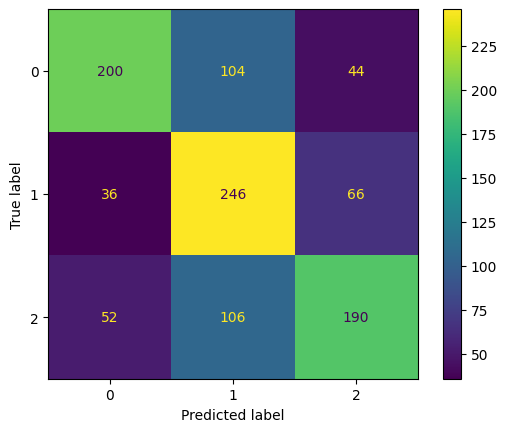

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    stock_df_processed['sentiment_score'], stock_df_processed['prediction_openai']
)

#### Check the probabilities returned by GPT by group

In [ ]:
stock_df_processed['probability'] = pred_df_openai['Probability'].values

In [ ]:
stock_df_processed

,id,created_at,tweet_body,sentiment_label,sentiment_score,prediction_openai,probability
0,721120,2020-06-30 13:04:48+00:00,"ya ya $Spx 3,400, spx 2,900, spx 2,600. i can ...",negative,0,2,0.8
1,11955,2020-04-09 05:58:02+00:00,This is not a favorable time to trade big. Why...,negative,0,0,0.9
2,802981,2020-07-07 06:39:45+00:00,RT @user Morning people!\n\n stocks are coming...,negative,0,1,0.6
3,34481,2020-04-13 20:18:54+00:00,$RCL lost over 16% and is Monday's worst perfo...,negative,0,0,0.8
4,558914,2020-06-17 11:26:58+00:00,RT @user We got the bounce to 3120 in $SPX and...,negative,0,1,0.6
...,...,...,...,...,...,...,...
1039,756997,2020-07-02 05:30:13+00:00,$AMZN - Amazon establishes new aerospace cloud...,positive,2,1,0.6
1040,33990,2020-04-13 21:00:53+00:00,Don't miss our next FREE OPTION TRADE. Sign u...,positive,2,2,0.8
1041,281634,2020-05-05 17:02:50+00:00,Microsoft $MSFT and Algorand $ALGO teams work...,positive,2,1,0.6
1042,458016,2020-06-08 05:45:53+00:00,Amazon isn’t the only e-commerce company thriv...,positive,2,2,0.8


In [ ]:
stock_df_processed.groupby(['sentiment_label'])['probability'].mean()

sentiment_label
negative    0.749425
neutral     0.666259
positive    0.762069
Name: probability, dtype: float64

<Axes: xlabel='probability', ylabel='Count'>

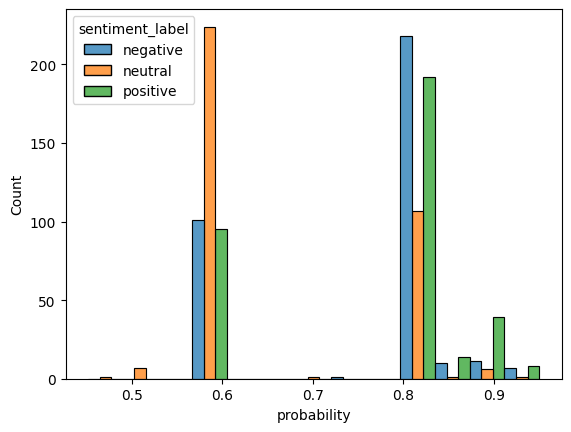

In [ ]:
sns.histplot(x = stock_df_processed['probability'], hue = stock_df_processed['sentiment_label'],
             multiple = "dodge")

In [ ]:
stock_df_processed.groupby(['sentiment_label'])['probability'].value_counts()#.reset_index(name='Count')

sentiment_label  probability
negative         0.800          218
                 0.600          101
                 0.900           11
                 0.850           10
                 0.950            7
                 0.750            1
neutral          0.600          224
                 0.800          107
                 0.500            6
                 0.900            6
                 0.452            1
                 0.506            1
                 0.700            1
                 0.850            1
                 0.950            1
positive         0.800          192
                 0.600           95
                 0.900           39
                 0.850           14
                 0.950            8
Name: probability, dtype: int64

- we can see the probabilities provided by GPT-3.5 only include a few possible values

## Compare OpenAI with Twitter Roberta on Testing Dataset

In [ ]:
# join the predictions from openai with the df_test
df_test_pred_openai = pd.merge(df_test, stock_df_processed[['id', 'prediction_openai']], how = 'left', on=['id'])

In [ ]:
print(classification_report(df_test_pred_openai['sentiment_score'], df_test_pred_openai['prediction_openai']))

              precision    recall  f1-score   support

           0       0.72      0.51      0.60        35
           1       0.50      0.60      0.55        35
           2       0.50      0.54      0.52        35

    accuracy                           0.55       105
   macro avg       0.57      0.55      0.56       105
weighted avg       0.57      0.55      0.56       105



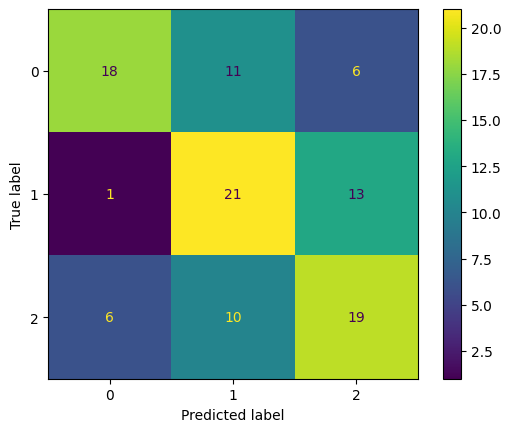

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    df_test_pred_openai['sentiment_score'], df_test_pred_openai['prediction_openai']
)

In [ ]:
prediction_roberta = pd.read_csv('/content/drive/MyDrive/prediction_roberta_fine_tuned.csv')

In [ ]:
print(classification_report(prediction_roberta['sentiment_score'], prediction_roberta['prediction_roberta_fine_tuned']))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75        35
           1       0.66      0.54      0.59        35
           2       0.59      0.66      0.62        35

    accuracy                           0.66       105
   macro avg       0.66      0.66      0.66       105
weighted avg       0.66      0.66      0.66       105



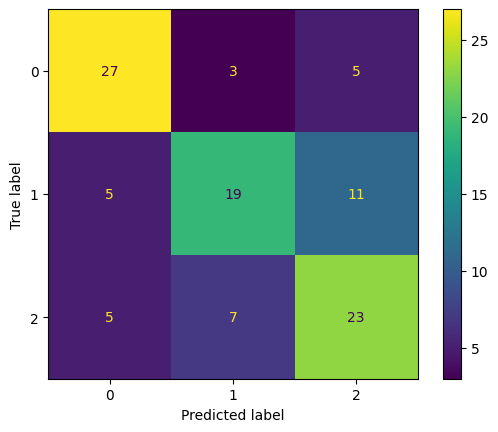

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    prediction_roberta['sentiment_score'], prediction_roberta['prediction_roberta_fine_tuned']
)

- for this specific testing dataset, the accuracy of using OpenAI is 0.55, which is lower than 0.66 from fine-tuned twitter-roberta-base-sentiment-latest model